# LIGHTGBM BINARY
https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

Control Params | Core Params | Metric Params | IO Params
-------------- | ----------- | ------------- | ---------
max_depth | task | metric (mae, mse, binary_logloss, multi_logloss) | max_bin
min_data_in_leaf | application (regression, binary, multiclass)| categorical_feature
feature_fraction | boosting (gbdt, rf, dark, goss) | ignore_column
bagging_fraction | num_boost_round | save_binary
early_stopping_round | learning_rate
lambda | num_leaves
min_gain_to_split | device (GPU or CPU)
max_cat_group | 

In [1]:
%load_ext chime
%matplotlib inline

import os
from glob import glob
import pickle
import chime

from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, cohen_kappa_score, classification_report
from skimage.exposure import adjust_sigmoid
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import rasterio as rio
from rasterio.windows import from_bounds

import pandas as pd
import geopandas as gpd
import numpy as np

from datetime import datetime
import json

import matplotlib.pyplot as plt
import lightgbm as lgb

import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from utils import *

import optuna.integration.lightgbm as olgb

In [2]:
"""
def calcMeanDiffs(df, headers):
    #
    #Given a dataframe containing columns of RED, GREEN, BLUE, and NIR, calculate their difference from the mean of the others. Add these new columns to the headers to be used
    #
    df["REDness"] = df.apply(lambda r: calcMeanDiff(r, "RED"), axis=1)
    df["GREENness"] = df.apply(lambda r: calcMeanDiff(r, "GREEN"), axis=1)
    df["BLUEness"] = df.apply(lambda r: calcMeanDiff(r, "BLUE"), axis=1)
    df["NIRness"] = df.apply(lambda r: calcMeanDiff(r, "NIR"), axis=1)
    df["RGBNmean"] = np.nanmean([df["RED"], df["GREEN"], df["BLUE"], df["NIR"]], axis=0)

    if "REDness" not in headers:
        headers += ["REDness", "GREENness", "BLUEness", "NIRness", "BaseMean"]
    return df, headers
"""

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return np.mean(errors), accuracy


def buildModel(params, dataset, features, classCol, fullReport=False, writeOut=False):
    """ Given parameters, a pandas dataframe, a list of feature column names, and the name of the class column"""
    X = dataset[features]
    y = dataset[classCol]
    X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=0.25, random_state=7)
    train_data = lgb.Dataset(X_train, label=Y_train)
    valid_data = lgb.Dataset(X_valid, label=Y_valid, reference=train_data)
    gbmModel = lgb.LGBMClassifier(**params, metric="custom")
    
    gbmModel.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), eval_metric=evalF1, early_stopping_rounds=50)#, verbose_eval=False)
    
    preds = gbmModel.predict(X_valid)

    scores = {}
    f1 = f1_score(Y_valid, preds, average='weighted')

    scores["F1"] = f1
    
    if fullReport:
        accuracy = accuracy_score(Y_valid, preds)
        kappa = cohen_kappa_score(Y_valid, preds)
        print(f"Model:\n\tAccuracy: {accuracy}\n\tF1: {f1}\n\tCohensKappa: {kappa}")
        print(classification_report(Y_valid, preds, target_names=[k for k,v in values_2019_lookup.items()][:-2]))#
        plotConfusionMatrix(gbmModel, X_valid, Y_valid)
    if writeOut:
        day = datetime.strftime(datetime.now(), "%Y%m%d")
        model_name = f"lightGBM_{day}.sav"
        model_path = os.path.join(os.path.abspath("./Models"), model_name)
        pickle.dump(gbmModel, open(model_path, "wb"))
        params_path = f"./Models/LGBMClassifierParams_{day}.txt"
        with open(params_path, "w+") as txt:
            txt.write(json.dumps(params))
        print(f"Wrote out trained model to \n\t{model_path} and paramameters to \n\t{params_path}")
    
    return gbmModel, scores


def optunaObjective(trial):
    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "multi_logloss")
    
    search_params = {
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 0.5),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 0.5),
        "num_leaves": trial.suggest_int("num_leaves", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 10, 100),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.5),
        "num_boost_round": trial.suggest_int("num_boost_round", 25, 400), # change min limit to 25 because best fits were hitting limit of 50 
        "boosting_type": trial.suggest_categorical('boosting_type', ["rf", "gbdt"]), # used dart on previous searches. not best for this
        "n_estimators": trial.suggest_int("n_estimators", 100, 500)
    }
    
    params = {**fixed_params, **search_params}
    scores = []
    for data in subGroups:
        #data = subGroups[i]
        gbm, modelScores = buildModel(params, data, featureHeaders, class_col)
                
        #preds = gbm.predict(X_valid)
        #accuracy = accuracy_score(y_valid, preds)
        #f1 = f1_score(y_valid, preds, average='weighted')
        scores.append(modelScores["F1"])
        
    meanScore = np.mean(scores)
    
    return meanScore


def evaluate_macroF1_lgb(truth, predictions):  
    #pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='weighted')
    return ('macroF1', f1, True) 


def plotConfusionMatrix(model, xValid, yValid):
    labels, counts = np.unique(yValid, return_counts=True)
    pred_lgb = model.predict(xValid)
    cm = confusion_matrix(yValid, pred_lgb, labels=labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)


    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=[k for i in labels for k,v in values_2019_lookup.items() if i == v],
           yticklabels=[k for i in labels for k,v in values_2019_lookup.items() if i == v],
           title='Normalized Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')


    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.4f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()


def evalF1(y_true, y_pred):
    #https://stackoverflow.com/questions/57222667/light-gbm-early-stopping-does-not-work-for-custom-metric
    # returns (eval_name, eval_result, is_higher_better
    y_pred = y_pred.reshape(len(np.unique(y_true)),-1).argmax(axis=0)
    return 'F1', f1_score(y_true, y_pred, average='weighted'), True

In [4]:
trainingSamples_locs = {"PondLake": "../OtherData/TrainingData/PondLake_20210519.pickle",
                        "Pool": "../OtherData/TrainingData/Pool_20210519.pickle",
                        "DenseVeg": "../OtherData/TrainingData/DenseVeg_20210519.pickle",
                        "IrrigatedLand": "../OtherData/TrainingData/IrrigatedLand_20210519.pickle",
                        "Asphault": "../OtherData/TrainingData/Asphault_20210519.pickle",
                        "Impervious": "../OtherData/TrainingData/Impervious_20210519.pickle",
                        "Structure": "../OtherData/TrainingData/Structure_20210519.pickle",
                        "Barren": "../OtherData/TrainingData/Barren_20210519.pickle",
                        "SparseVeg": "../OtherData/TrainingData/SparseVeg_20210519.pickle",
                        "ParkingLot": "../OtherData/TrainingData/ParkingLot_20210519.pickle",
                        "Sidewalk": "../OtherData/TrainingData/Sidewalk_20210519.pickle"}

values_2019_lookup = {"PondLake": 1, "Pool": 2, "Barren": 3, "SparseVeg": 4, "DenseVeg": 5, "IrrigatedLand": 6, "Asphault": 7, "Impervious": 8, "Structure": 9, "ParkingLot": 7, "Sidewalk": 8}
for lcclass, fileloc in trainingSamples_locs.items():
    trainingSamples_locs[lcclass] = fileloc.replace("20210519", "20210813")
trainingSamples_locs

{'PondLake': '../OtherData/TrainingData/PondLake_20210813.pickle',
 'Pool': '../OtherData/TrainingData/Pool_20210813.pickle',
 'DenseVeg': '../OtherData/TrainingData/DenseVeg_20210813.pickle',
 'IrrigatedLand': '../OtherData/TrainingData/IrrigatedLand_20210813.pickle',
 'Asphault': '../OtherData/TrainingData/Asphault_20210813.pickle',
 'Impervious': '../OtherData/TrainingData/Impervious_20210813.pickle',
 'Structure': '../OtherData/TrainingData/Structure_20210813.pickle',
 'Barren': '../OtherData/TrainingData/Barren_20210813.pickle',
 'SparseVeg': '../OtherData/TrainingData/SparseVeg_20210813.pickle',
 'ParkingLot': '../OtherData/TrainingData/ParkingLot_20210813.pickle',
 'Sidewalk': '../OtherData/TrainingData/Sidewalk_20210813.pickle'}

In [5]:
class_col = "LCClassInt"

trainingSamples = []
for lcClass, file in trainingSamples_locs.items():
    df = pd.read_pickle(file)
    if lcClass == "Structure":
        df = df[df.HAG >= 6]
        
    if lcClass == "PondLake" or lcClass == "Pool" or lcClass == "IrrigatedLand" or lcClass == "Impervious" or lcClass == "Barren" or lcClass == "Asphault":
        df = df[df.HAG == 0] 
        
    if lcClass == "PondLake":
        df = df[df.MSAVI < (120/255)*np.iinfo(np.uint16).max]
        df = df[df.NDVI < (15/255)*np.iinfo(np.uint16).max]
        
    if lcClass == "Pool":
        df = df[df.MSAVI < (100/255)*np.iinfo(np.uint16).max]
        df = df[df.NDVI < (65/255)*np.iinfo(np.uint16).max]
        
    if lcClass == "Asphault" or lcClass == "ParkingLot":
        df.loc[df.NIR >= (100/255)*np.iinfo(np.uint16).max, "LCClass"] = "Impervious"
        
    trainingSamples.append(df)
    
trainingSamples = pd.concat(trainingSamples).reset_index(drop=True)

print(trainingSamples.shape)

trainingSamples[class_col] = trainingSamples["LCClass"].apply(lambda lcc: values_2019_lookup[lcc])

local_class_weight_dict = {"PondLake": 0.02,
                           "Pool": 0.10,
                           "Barren": 24,
                           "SparseVeg": 18,
                           "DenseVeg": 15,
                           "IrrigatedLand": 3,
                           "Asphault": 11,
                           "Impervious": 14,
                           "Structure": 14.88}

# replace human readable names with numerical associations
local_class_weight_dict = { values_2019_lookup[k]: v for k, v in local_class_weight_dict.items() }

print(f"Total weights: {np.sum([v for v in local_class_weight_dict.values()])}")

%chime

(40519977, 28)
Total weights: 100.0


In [6]:
trainingFeaturesToUse = trainingSamples.columns.tolist()
#trainingFeaturesToUse = [fn for fn in trainingFeaturesToUse if "GaussianSigma5" not in fn]
#trainingFeaturesToUse = [fn for fn in trainingFeaturesToUse if "Segment_" not in fn]
trainingFeaturesToUse.remove("LCClass")
trainingFeaturesToUse.remove("LCClassInt")
trainingFeaturesToUse

['RED',
 'GREEN',
 'BLUE',
 'NIR',
 'MSAVI',
 'NDVI',
 'NDPI',
 'REDness',
 'GREENness',
 'BLUEness',
 'NIRness',
 'HAG',
 'DPR',
 'GaussianSigma2_RED',
 'GaussianSigma2_GREEN',
 'GaussianSigma2_BLUE',
 'GaussianSigma2_NIR',
 'GaussianSigma5_RED',
 'GaussianSigma5_GREEN',
 'GaussianSigma5_BLUE',
 'GaussianSigma5_NIR',
 'Segment_area',
 'Segment_extent',
 'Segment_eccentricity',
 'Segment_perimeter',
 'X',
 'Y']

In [6]:
trainingSamples.LCClass.value_counts()

Impervious       5578105
SparseVeg        5156222
Structure        4741328
Barren           4701539
IrrigatedLand    4440013
DenseVeg         4274182
Asphault         4260472
Pool             2801571
ParkingLot       2458928
Sidewalk         1053878
PondLake          514561
Name: LCClass, dtype: int64

In [7]:
%%time
subGroups = []
sampleSize = 200000
#sampleSize = min(10**6, trainingSamples.LCClassInt.value_counts().min()) # large sample size did not improve classification

for i in range(3):
    start = datetime.now()
    trainingSamples_sub = getSubSample(data=trainingSamples, maxSampSize=sampleSize, features_cols=trainingFeaturesToUse[:], class_column=class_col)
    trainingSamples_sub["RGBNmean"] = trainingSamples_sub.apply(lambda r: np.nanmean([r.RED, r.GREEN, r.BLUE, r.NIR]), axis=1)
    subGroups.append(trainingSamples_sub)
    print(f"Done {i} - {datetime.now()-start}")
    
%chime

featureHeaders = trainingFeaturesToUse[:]
featureHeaders.append("RGBNmean")

Done 0 - 0:02:03.430473
Done 1 - 0:02:06.205070
Done 2 - 0:02:06.682276
Wall time: 6min 16s


In [27]:
import mlflow
import optuna
import optuna.integration.lightgbm as olgb


def mlflow_callback(study, trial):
    trial_value = trial.value if trial.value is not None else float("nan")

    trial_runtime = float("nan")
    if trial.datetime_start and trial.datetime_complete:
        trial_runtime = (trial.datetime_complete - trial.datetime_start).total_seconds()
    
    with mlflow.start_run(run_name=study.study_name):
        mlflow.log_params(trial.params)
        #mlflow.log_params({"step_name": trial.user_attrs["lightgbm_tuner:step_number"]})
        
        mlflow.log_metrics({
            "trial_number": trial.number,
            "elapsed_time": trial_runtime,
            "mean_squared_error": trial_value,
        })
                          
sampleSize = 500000
trainingFeaturesToUse = trainingSamples.columns.tolist()
trainingFeaturesToUse.remove("LCClass")
trainingFeaturesToUse.remove("LCClassInt")
# Segment area was shown to be high-leverage and inaccurate for binary classification of asphault (2021-06-16)


values_2019_lookup = {"PondLake": 1,
                      "Pool": 2,
                      "Barren": 3,
                      "SparseVeg": 4,
                      "DenseVeg": 5,
                      "IrrigatedLand": 6,
                      "Asphault": 7,
                      "Impervious": 8,
                      "Structure": 9,
                      "ParkingLot": 7,
                      "Sidewalk": 8}

trainingSamples_sub = getSubSample(data=trainingSamples, maxSampSize=sampleSize, features_cols=trainingFeaturesToUse[:], class_column=class_col)
trainingSamples_sub["RGBNmean"] = np.nanmean([trainingSamples_sub["RED"], trainingSamples_sub["GREEN"], trainingSamples_sub["BLUE"], trainingSamples_sub["NIR"]], axis=0)
trainingFeaturesToUse.append("RGBNmean")

print("Training Features:\n",trainingFeaturesToUse)

studies = {}

for k,v in values_2019_lookup.items():
    classTrainingFeaturesToUse = trainingFeaturesToUse[:]
    if k != "Asphault":
        continue
    if k == "Asphault":
        classTrainingFeaturesToUse.remove("Segment_area") 
    elif k == "Structure":
        classTrainingFeaturesToUse = [feat for feat in classTrainingFeaturesToUse if "GaussianSigma5_" not in feat]
    elif k != "DenseVeg":
        continue

    start = datetime.now()

    print(f"Starting training of binary model for {k}")
    dataset = trainingSamples_sub.copy()
    # separate all training into binary structure and not
    dataset[class_col] = dataset[class_col].apply(lambda cc: 1 if cc == v else 0)

    X = dataset[classTrainingFeaturesToUse]
    y = dataset[class_col]
    X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=0.25, random_state=7)

    dtrain = lgb.Dataset(X_train, label=Y_train)
    dval = lgb.Dataset(X_valid, label=Y_valid)

    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "bagging_fraction": 0.8,
        "min_child_samples": int(0.01*sampleSize),
        "early_stopping_round": 50,
        "n_jobs": 8,
    }
    
    study = optuna.create_study(study_name=f"lightgbm_tuner_{k}", direction="minimize")
    
    model = olgb.train(
        params, train_set=dtrain, valid_sets=[dtrain, dval], verbose_eval=100,
        optuna_callbacks=[mlflow_callback], study=study
    )

    studies[k]=study
    
    prediction = np.rint(model.predict(X_valid, num_iteration=model.best_iteration))
    accuracy = accuracy_score(Y_valid, prediction)

    best_params = model.params
    print(f"Best params for {k}:", best_params)
    print(f"  {k} Accuracy = {accuracy}")
    print("  Params: ")
    for key, value in best_params.items():
        print(f"    {key}: {value}")
        
        
    day = datetime.strftime(datetime.now(), "%Y%m%d")
    model_name = f"lightGBMBinary{k}_{day}.sav"
    model_path = os.path.join(os.path.abspath("../notebooks/Models"), model_name)
    pickle.dump(model, open(model_path, "wb"))
    params_path = f"../notebooks/Models/lightBinary{k}Params_{day}.txt"
    with open(params_path, "w+") as txt:
        txt.write(json.dumps(params))
        print(f"Wrote out trained model for {k} to \n\t{model_path} and paramameters to \n\t{params_path}")
    end = datetime.now()
    print(f"Training took {end-start}\n")
    break

Training Features:
 ['RED', 'GREEN', 'BLUE', 'NIR', 'MSAVI', 'NDVI', 'NDPI', 'REDness', 'GREENness', 'BLUEness', 'NIRness', 'HAG', 'DPR', 'GaussianSigma2_RED', 'GaussianSigma2_GREEN', 'GaussianSigma2_BLUE', 'GaussianSigma2_NIR', 'GaussianSigma5_RED', 'GaussianSigma5_GREEN', 'GaussianSigma5_BLUE', 'GaussianSigma5_NIR', 'Segment_area', 'Segment_extent', 'Segment_eccentricity', 'Segment_perimeter', 'RGBNmean']
Starting training of binary model for Asphault


[I 2021-07-27 10:57:04,673] A new study created in memory with name: lightgbm_tuner_Asphault

feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00207501	valid_1's binary_logloss: 0.00220363
[200]	valid_0's binary_logloss: 0.00112777	valid_1's binary_logloss: 0.00156233
[300]	valid_0's binary_logloss: 0.000729742	valid_1's binary_logloss: 0.00129197
[400]	valid_0's binary_logloss: 0.000506245	valid_1's binary_logloss: 0.00114089
[500]	valid_0's binary_logloss: 0.000362536	valid_1's binary_logloss: 0.00104451
[600]	valid_0's binary_logloss: 0.000260459	valid_1's binary_logloss: 0.000988154
[700]	valid_0's binary_logloss: 0.000184217	valid_1's binary_logloss: 0.000940191
[800]	valid_0's binary_logloss: 0.000132518	valid_1's binary_logloss: 0.000911535
[900]	valid_0's binary_logloss: 9.59088e-05	valid_1's binary_logloss: 0.000892324



feature_fraction, val_score: 0.000883:  14%|######2                                     | 1/7 [01:53<11:22, 113.69s/it][I 2021-07-27 10:58:58,385] Trial 0 finished with value: 0.0008830168419893462 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.0008830168419893462.


[1000]	valid_0's binary_logloss: 7.03412e-05	valid_1's binary_logloss: 0.000883017
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 7.03412e-05	valid_1's binary_logloss: 0.000883017



feature_fraction, val_score: 0.000883:  14%|######2                                     | 1/7 [01:53<11:22, 113.69s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00178649	valid_1's binary_logloss: 0.00194424
[200]	valid_0's binary_logloss: 0.000976284	valid_1's binary_logloss: 0.00138784



feature_fraction, val_score: 0.000883:  29%|############8                                | 2/7 [02:34<07:39, 91.87s/it][I 2021-07-27 10:59:39,337] Trial 1 finished with value: 0.0013073238241941745 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.0008830168419893462.

feature_fraction, val_score: 0.000883:  29%|############8                                | 2/7 [02:34<07:39, 91.87s/it]

Early stopping, best iteration is:
[228]	valid_0's binary_logloss: 0.000856596	valid_1's binary_logloss: 0.00130732
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00175794	valid_1's binary_logloss: 0.00191843
[200]	valid_0's binary_logloss: 0.000943048	valid_1's binary_logloss: 0.00132137
[300]	valid_0's binary_logloss: 0.000623216	valid_1's binary_logloss: 0.00112022
[400]	valid_0's binary_logloss: 0.000406086	valid_1's binary_logloss: 0.000983663
[500]	valid_0's binary_logloss: 0.000276381	valid_1's binary_logloss: 0.000906714
[600]	valid_0's binary_logloss: 0.000187504	valid_1's binary_logloss: 0.000861578
[700]	valid_0's binary_logloss: 0.000127441	valid_1's binary_logloss: 0.000830445
[800]	valid_0's binary_logloss: 8.80831e-05	valid_1's binary_logloss: 0.000815365
[900]	valid_0's binary_logloss: 6.10454e-05	valid_1's binary_logloss: 0.000808556



feature_fraction, val_score: 0.000807:  43%|##################8                         | 3/7 [04:44<06:53, 103.28s/it][I 2021-07-27 11:01:49,265] Trial 2 finished with value: 0.0008069199153780965 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 0.0008069199153780965.


Early stopping, best iteration is:
[918]	valid_0's binary_logloss: 5.7551e-05	valid_1's binary_logloss: 0.00080692



feature_fraction, val_score: 0.000807:  43%|##################8                         | 3/7 [04:44<06:53, 103.28s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00188967	valid_1's binary_logloss: 0.00203652
[200]	valid_0's binary_logloss: 0.00100827	valid_1's binary_logloss: 0.00133935
[300]	valid_0's binary_logloss: 0.000661245	valid_1's binary_logloss: 0.00111282
[400]	valid_0's binary_logloss: 0.000457433	valid_1's binary_logloss: 0.000992137
[500]	valid_0's binary_logloss: 0.000316209	valid_1's binary_logloss: 0.000912875
[600]	valid_0's binary_logloss: 0.000220582	valid_1's binary_logloss: 0.000857604
[700]	valid_0's binary_logloss: 0.000155486	valid_1's binary_logloss: 0.000825567
[800]	valid_0's binary_logloss: 0.000111251	valid_1's binary_logloss: 0.000806259
[900]	valid_0's binary_logloss: 7.88322e-05	valid_1's binary_logloss: 0.000795347



feature_fraction, val_score: 0.000788:  57%|#########################1                  | 4/7 [06:41<05:22, 107.35s/it]

[1000]	valid_0's binary_logloss: 5.6129e-05	valid_1's binary_logloss: 0.000788189
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 5.6129e-05	valid_1's binary_logloss: 0.000788189


[I 2021-07-27 11:03:46,102] Trial 3 finished with value: 0.0007881885783415666 and parameters: {'feature_fraction': 0.5}. Best is trial 3 with value: 0.0007881885783415666.

feature_fraction, val_score: 0.000788:  57%|#########################1                  | 4/7 [06:41<05:22, 107.35s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.0018361	valid_1's binary_logloss: 0.00198332
[200]	valid_0's binary_logloss: 0.001067	valid_1's binary_logloss: 0.00140577
[300]	valid_0's binary_logloss: 0.00108635	valid_1's binary_logloss: 0.0017126



feature_fraction, val_score: 0.000788:  71%|################################1            | 5/7 [07:26<02:57, 88.56s/it][I 2021-07-27 11:04:30,802] Trial 4 finished with value: 0.0011868599659357773 and parameters: {'feature_fraction': 0.6}. Best is trial 3 with value: 0.0007881885783415666.

feature_fraction, val_score: 0.000788:  71%|################################1            | 5/7 [07:26<02:57, 88.56s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.000740476	valid_1's binary_logloss: 0.00118686
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00173308	valid_1's binary_logloss: 0.00190541
[200]	valid_0's binary_logloss: 0.000938894	valid_1's binary_logloss: 0.00139148
[300]	valid_0's binary_logloss: 0.00059732	valid_1's binary_logloss: 0.0011602
[400]	valid_0's binary_logloss: 0.000392231	valid_1's binary_logloss: 0.0010184
[500]	valid_0's binary_logloss: 0.000265289	valid_1's binary_logloss: 0.000934904
[600]	valid_0's binary_logloss: 0.000178369	valid_1's binary_logloss: 0.000886297
[700]	valid_0's binary_logloss: 0.000121641	valid_1's binary_logloss: 0.000850642
[800]	valid_0's binary_logloss: 8.23906e-05	valid_1's binary_logloss: 0.000833455
[900]	valid_0's binary_logloss: 5.63231e-05	valid_1's binary_logloss: 0.000820716



feature_fraction, val_score: 0.000788:  86%|#####################################7      | 6/7 [09:38<01:41, 101.77s/it][I 2021-07-27 11:06:43,399] Trial 5 finished with value: 0.00081993859433085 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 3 with value: 0.0007881885783415666.


Early stopping, best iteration is:
[906]	valid_0's binary_logloss: 5.5147e-05	valid_1's binary_logloss: 0.000819939



feature_fraction, val_score: 0.000788:  86%|#####################################7      | 6/7 [09:38<01:41, 101.77s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00172838	valid_1's binary_logloss: 0.00189997
[200]	valid_0's binary_logloss: 0.000911733	valid_1's binary_logloss: 0.00130163
[300]	valid_0's binary_logloss: 0.000576768	valid_1's binary_logloss: 0.00109771
[400]	valid_0's binary_logloss: 0.000376112	valid_1's binary_logloss: 0.000983389
[500]	valid_0's binary_logloss: 0.000248629	valid_1's binary_logloss: 0.000917182
[600]	valid_0's binary_logloss: 0.000169389	valid_1's binary_logloss: 0.000870826
[700]	valid_0's binary_logloss: 0.000117024	valid_1's binary_logloss: 0.000849155
[800]	valid_0's binary_logloss: 7.94304e-05	valid_1's binary_logloss: 0.000831332
[900]	valid_0's binary_logloss: 5.45506e-05	valid_1's binary_logloss: 0.000827968



feature_fraction, val_score: 0.000788: 100%|############################################| 7/7 [11:50<00:00, 110.85s/it][I 2021-07-27 11:08:55,463] Trial 6 finished with value: 0.0008240072887643516 and parameters: {'feature_fraction': 1.0}. Best is trial 3 with value: 0.0007881885783415666.


Early stopping, best iteration is:
[869]	valid_0's binary_logloss: 6.0623e-05	valid_1's binary_logloss: 0.000824007


feature_fraction, val_score: 0.000788: 100%|############################################| 7/7 [11:50<00:00, 101.55s/it]

num_leaves, val_score: 0.000788:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00126825	valid_1's binary_logloss: 0.00157556
[200]	valid_0's binary_logloss: 0.00019562	valid_1's binary_logloss: 0.000845019
[300]	valid_0's binary_logloss: 3.28517e-05	valid_1's binary_logloss: 0.000785792



num_leaves, val_score: 0.000783:   5%|##5                                               | 1/20 [01:18<24:47, 78.30s/it]

Early stopping, best iteration is:
[276]	valid_0's binary_logloss: 5.01504e-05	valid_1's binary_logloss: 0.000783081


[I 2021-07-27 11:10:13,888] Trial 7 finished with value: 0.0007830812745130991 and parameters: {'num_leaves': 197}. Best is trial 7 with value: 0.0007830812745130991.

num_leaves, val_score: 0.000783:   5%|##5                                               | 1/20 [01:18<24:47, 78.30s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00126782	valid_1's binary_logloss: 0.00158015
[200]	valid_0's binary_logloss: 0.000195525	valid_1's binary_logloss: 0.000846887
[300]	valid_0's binary_logloss: 3.51665e-05	valid_1's binary_logloss: 0.000796849



num_leaves, val_score: 0.000783:  10%|#####                                             | 2/20 [02:36<23:28, 78.24s/it][I 2021-07-27 11:11:32,007] Trial 8 finished with value: 0.0007929484088576611 and parameters: {'num_leaves': 189}. Best is trial 7 with value: 0.0007830812745130991.


Early stopping, best iteration is:
[281]	valid_0's binary_logloss: 4.86546e-05	valid_1's binary_logloss: 0.000792948



num_leaves, val_score: 0.000783:  10%|#####                                             | 2/20 [02:36<23:28, 78.24s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00421682	valid_1's binary_logloss: 0.00420297
[200]	valid_0's binary_logloss: 0.00275787	valid_1's binary_logloss: 0.00280259
[300]	valid_0's binary_logloss: 0.0022566	valid_1's binary_logloss: 0.00233411
[400]	valid_0's binary_logloss: 0.00193973	valid_1's binary_logloss: 0.00205222
[500]	valid_0's binary_logloss: 0.00172972	valid_1's binary_logloss: 0.0018814
[600]	valid_0's binary_logloss: 0.00156819	valid_1's binary_logloss: 0.00174776
[700]	valid_0's binary_logloss: 0.00143949	valid_1's binary_logloss: 0.00164635
[800]	valid_0's binary_logloss: 0.00134793	valid_1's binary_logloss: 0.00158106
[900]	valid_0's binary_logloss: 0.00124484	valid_1's binary_logloss: 0.00150917



num_leaves, val_score: 0.000783:  15%|#######5                                          | 3/20 [03:56<22:21, 78.88s/it][I 2021-07-27 11:12:52,377] Trial 9 finished with value: 0.0014505294968608343 and parameters: {'num_leaves': 6}. Best is trial 7 with value: 0.0007830812745130991.

num_leaves, val_score: 0.000783:  15%|#######5                                          | 3/20 [03:56<22:21, 78.88s/it]

[1000]	valid_0's binary_logloss: 0.00116127	valid_1's binary_logloss: 0.00145053
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.00116127	valid_1's binary_logloss: 0.00145053
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00168392	valid_1's binary_logloss: 0.00186176
[200]	valid_0's binary_logloss: 0.000780214	valid_1's binary_logloss: 0.00119303
[300]	valid_0's binary_logloss: 0.000449729	valid_1's binary_logloss: 0.000987724
[400]	valid_0's binary_logloss: 0.00026328	valid_1's binary_logloss: 0.000880179
[500]	valid_0's binary_logloss: 0.000159636	valid_1's binary_logloss: 0.000823418
[600]	valid_0's binary_logloss: 9.7062e-05	valid_1's binary_logloss: 0.00079402
[700]	valid_0's binary_logloss: 6.00907e-05	valid_1's binary_logloss: 0.000786153



num_leaves, val_score: 0.000783:  20%|##########                                        | 4/20 [05:34<22:31, 84.49s/it][I 2021-07-27 11:14:29,949] Trial 10 finished with value: 0.0007831193822447332 and parameters: {'num_leaves': 44}. Best is trial 7 with value: 0.0007830812745130991.


Early stopping, best iteration is:
[721]	valid_0's binary_logloss: 5.46754e-05	valid_1's binary_logloss: 0.000783119



num_leaves, val_score: 0.000783:  20%|##########                                        | 4/20 [05:34<22:31, 84.49s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00126178	valid_1's binary_logloss: 0.00156769
[200]	valid_0's binary_logloss: 0.000209871	valid_1's binary_logloss: 0.000865068
[300]	valid_0's binary_logloss: 3.92623e-05	valid_1's binary_logloss: 0.000804434



num_leaves, val_score: 0.000783:  25%|############5                                     | 5/20 [06:50<20:29, 81.95s/it][I 2021-07-27 11:15:45,962] Trial 11 finished with value: 0.0008020862487967262 and parameters: {'num_leaves': 172}. Best is trial 7 with value: 0.0007830812745130991.


Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 5.08655e-05	valid_1's binary_logloss: 0.000802086



num_leaves, val_score: 0.000783:  25%|############5                                     | 5/20 [06:50<20:29, 81.95s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00161455	valid_1's binary_logloss: 0.00180581
[200]	valid_0's binary_logloss: 0.000694913	valid_1's binary_logloss: 0.00113421
[300]	valid_0's binary_logloss: 0.000375682	valid_1's binary_logloss: 0.00094537
[400]	valid_0's binary_logloss: 0.000209925	valid_1's binary_logloss: 0.000851496
[500]	valid_0's binary_logloss: 0.000117511	valid_1's binary_logloss: 0.000806378
[600]	valid_0's binary_logloss: 6.70645e-05	valid_1's binary_logloss: 0.00078975
[700]	valid_0's binary_logloss: 3.95036e-05	valid_1's binary_logloss: 0.000787375



num_leaves, val_score: 0.000783:  30%|###############                                   | 6/20 [08:33<20:36, 88.34s/it][I 2021-07-27 11:17:29,207] Trial 12 finished with value: 0.000784833273375585 and parameters: {'num_leaves': 50}. Best is trial 7 with value: 0.0007830812745130991.


Early stopping, best iteration is:
[660]	valid_0's binary_logloss: 4.84783e-05	valid_1's binary_logloss: 0.000784833



num_leaves, val_score: 0.000783:  30%|###############                                   | 6/20 [08:33<20:36, 88.34s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00125633	valid_1's binary_logloss: 0.00157749
[200]	valid_0's binary_logloss: 0.000174949	valid_1's binary_logloss: 0.000833659
[300]	valid_0's binary_logloss: 2.83055e-05	valid_1's binary_logloss: 0.000785819



num_leaves, val_score: 0.000782:  35%|#################5                                | 7/20 [09:59<18:59, 87.62s/it][I 2021-07-27 11:18:55,166] Trial 13 finished with value: 0.0007817867765276667 and parameters: {'num_leaves': 247}. Best is trial 13 with value: 0.0007817867765276667.


Early stopping, best iteration is:
[281]	valid_0's binary_logloss: 4.02784e-05	valid_1's binary_logloss: 0.000781787



num_leaves, val_score: 0.000782:  35%|#################5                                | 7/20 [09:59<18:59, 87.62s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00145348	valid_1's binary_logloss: 0.00168606
[200]	valid_0's binary_logloss: 0.000483017	valid_1's binary_logloss: 0.00101131
[300]	valid_0's binary_logloss: 0.000202022	valid_1's binary_logloss: 0.000842607
[400]	valid_0's binary_logloss: 8.91629e-05	valid_1's binary_logloss: 0.000787197
[500]	valid_0's binary_logloss: 3.98049e-05	valid_1's binary_logloss: 0.000783451



num_leaves, val_score: 0.000779:  40%|####################                              | 8/20 [11:22<17:15, 86.30s/it][I 2021-07-27 11:20:18,361] Trial 14 finished with value: 0.0007789959049833483 and parameters: {'num_leaves': 73}. Best is trial 14 with value: 0.0007789959049833483.


Early stopping, best iteration is:
[476]	valid_0's binary_logloss: 4.82476e-05	valid_1's binary_logloss: 0.000778996



num_leaves, val_score: 0.000779:  40%|####################                              | 8/20 [11:22<17:15, 86.30s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00128211	valid_1's binary_logloss: 0.00158294
[200]	valid_0's binary_logloss: 0.0002047	valid_1's binary_logloss: 0.000854555
[300]	valid_0's binary_logloss: 3.83183e-05	valid_1's binary_logloss: 0.00078904



num_leaves, val_score: 0.000779:  45%|######################5                           | 9/20 [12:45<15:37, 85.21s/it][I 2021-07-27 11:21:41,034] Trial 15 finished with value: 0.0007853882273740718 and parameters: {'num_leaves': 173}. Best is trial 14 with value: 0.0007789959049833483.


Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 3.33239e-05	valid_1's binary_logloss: 0.000785388



num_leaves, val_score: 0.000779:  45%|######################5                           | 9/20 [12:45<15:37, 85.21s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00154633	valid_1's binary_logloss: 0.00176325
[200]	valid_0's binary_logloss: 0.000598827	valid_1's binary_logloss: 0.00106491
[300]	valid_0's binary_logloss: 0.000286622	valid_1's binary_logloss: 0.000875637
[400]	valid_0's binary_logloss: 0.000147452	valid_1's binary_logloss: 0.00080107
[500]	valid_0's binary_logloss: 7.59775e-05	valid_1's binary_logloss: 0.000778822



num_leaves, val_score: 0.000775:  50%|########################5                        | 10/20 [14:08<14:06, 84.67s/it][I 2021-07-27 11:23:04,442] Trial 16 finished with value: 0.0007754586259655285 and parameters: {'num_leaves': 59}. Best is trial 16 with value: 0.0007754586259655285.



Early stopping, best iteration is:
[532]	valid_0's binary_logloss: 6.17926e-05	valid_1's binary_logloss: 0.000775459


num_leaves, val_score: 0.000775:  50%|########################5                        | 10/20 [14:08<14:06, 84.67s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00133466	valid_1's binary_logloss: 0.00161024
[200]	valid_0's binary_logloss: 0.000307811	valid_1's binary_logloss: 0.000893467
[300]	valid_0's binary_logloss: 8.92479e-05	valid_1's binary_logloss: 0.000778737
[400]	valid_0's binary_logloss: 2.77219e-05	valid_1's binary_logloss: 0.000786464



num_leaves, val_score: 0.000770:  55%|##########################9                      | 11/20 [15:27<12:25, 82.86s/it][I 2021-07-27 11:24:23,084] Trial 17 finished with value: 0.0007695372874709913 and parameters: {'num_leaves': 109}. Best is trial 17 with value: 0.0007695372874709913.


Early stopping, best iteration is:
[354]	valid_0's binary_logloss: 4.72893e-05	valid_1's binary_logloss: 0.000769537



num_leaves, val_score: 0.000770:  55%|##########################9                      | 11/20 [15:27<12:25, 82.86s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00132918	valid_1's binary_logloss: 0.00161075
[200]	valid_0's binary_logloss: 0.00030944	valid_1's binary_logloss: 0.000904892
[300]	valid_0's binary_logloss: 8.98296e-05	valid_1's binary_logloss: 0.00077999
[400]	valid_0's binary_logloss: 2.84745e-05	valid_1's binary_logloss: 0.000781086



num_leaves, val_score: 0.000770:  60%|#############################4                   | 12/20 [16:48<10:57, 82.21s/it][I 2021-07-27 11:25:43,770] Trial 18 finished with value: 0.0007722834147019454 and parameters: {'num_leaves': 108}. Best is trial 17 with value: 0.0007695372874709913.


Early stopping, best iteration is:
[356]	valid_0's binary_logloss: 4.69168e-05	valid_1's binary_logloss: 0.000772283



num_leaves, val_score: 0.000770:  60%|#############################4                   | 12/20 [16:48<10:57, 82.21s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00135146	valid_1's binary_logloss: 0.0016265
[200]	valid_0's binary_logloss: 0.000317942	valid_1's binary_logloss: 0.000910623
[300]	valid_0's binary_logloss: 9.55165e-05	valid_1's binary_logloss: 0.000787513
[400]	valid_0's binary_logloss: 3.06176e-05	valid_1's binary_logloss: 0.000785886



num_leaves, val_score: 0.000770:  65%|###############################8                 | 13/20 [18:05<09:24, 80.66s/it][I 2021-07-27 11:27:00,825] Trial 19 finished with value: 0.0007771828386940328 and parameters: {'num_leaves': 106}. Best is trial 17 with value: 0.0007695372874709913.



Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 5.09285e-05	valid_1's binary_logloss: 0.000777183


num_leaves, val_score: 0.000770:  65%|###############################8                 | 13/20 [18:05<09:24, 80.66s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00132091	valid_1's binary_logloss: 0.00160798
[200]	valid_0's binary_logloss: 0.000272817	valid_1's binary_logloss: 0.000877636
[300]	valid_0's binary_logloss: 6.97961e-05	valid_1's binary_logloss: 0.000780247



num_leaves, val_score: 0.000770:  70%|##################################3              | 14/20 [19:09<07:34, 75.68s/it][I 2021-07-27 11:28:04,888] Trial 20 finished with value: 0.000775853596216345 and parameters: {'num_leaves': 124}. Best is trial 17 with value: 0.0007695372874709913.


Early stopping, best iteration is:
[318]	valid_0's binary_logloss: 5.47542e-05	valid_1's binary_logloss: 0.000775854



num_leaves, val_score: 0.000770:  70%|##################################3              | 14/20 [19:09<07:34, 75.68s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00137498	valid_1's binary_logloss: 0.00163404
[200]	valid_0's binary_logloss: 0.000370252	valid_1's binary_logloss: 0.000933459
[300]	valid_0's binary_logloss: 0.000126907	valid_1's binary_logloss: 0.000803624
[400]	valid_0's binary_logloss: 4.63305e-05	valid_1's binary_logloss: 0.000781803



num_leaves, val_score: 0.000770:  75%|####################################7            | 15/20 [20:21<06:12, 74.55s/it][I 2021-07-27 11:29:16,787] Trial 21 finished with value: 0.0007778644649703279 and parameters: {'num_leaves': 92}. Best is trial 17 with value: 0.0007695372874709913.


Early stopping, best iteration is:
[389]	valid_0's binary_logloss: 5.13727e-05	valid_1's binary_logloss: 0.000777864



num_leaves, val_score: 0.000770:  75%|####################################7            | 15/20 [20:21<06:12, 74.55s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00128828	valid_1's binary_logloss: 0.00158853
[200]	valid_0's binary_logloss: 0.000232052	valid_1's binary_logloss: 0.000866682
[300]	valid_0's binary_logloss: 5.00396e-05	valid_1's binary_logloss: 0.000781714



num_leaves, val_score: 0.000770:  80%|#######################################2         | 16/20 [21:37<04:59, 74.93s/it][I 2021-07-27 11:30:32,621] Trial 22 finished with value: 0.0007798372345920619 and parameters: {'num_leaves': 146}. Best is trial 17 with value: 0.0007695372874709913.


Early stopping, best iteration is:
[302]	valid_0's binary_logloss: 4.85168e-05	valid_1's binary_logloss: 0.000779837



num_leaves, val_score: 0.000770:  80%|#######################################2         | 16/20 [21:37<04:59, 74.93s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00129152	valid_1's binary_logloss: 0.00158393
[200]	valid_0's binary_logloss: 0.000242681	valid_1's binary_logloss: 0.000862404
[300]	valid_0's binary_logloss: 5.51808e-05	valid_1's binary_logloss: 0.000788326



num_leaves, val_score: 0.000770:  85%|#########################################6       | 17/20 [22:46<03:39, 73.23s/it][I 2021-07-27 11:31:41,891] Trial 23 finished with value: 0.0007841558912161193 and parameters: {'num_leaves': 137}. Best is trial 17 with value: 0.0007695372874709913.



Early stopping, best iteration is:
[281]	valid_0's binary_logloss: 7.23114e-05	valid_1's binary_logloss: 0.000784156


num_leaves, val_score: 0.000770:  85%|#########################################6       | 17/20 [22:46<03:39, 73.23s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00281312	valid_1's binary_logloss: 0.00285951
[200]	valid_0's binary_logloss: 0.00181275	valid_1's binary_logloss: 0.00195803
[300]	valid_0's binary_logloss: 0.00146452	valid_1's binary_logloss: 0.0016793



num_leaves, val_score: 0.000770:  90%|############################################1    | 18/20 [23:25<02:06, 63.08s/it][I 2021-07-27 11:32:21,270] Trial 24 finished with value: 0.0016333292190731635 and parameters: {'num_leaves': 12}. Best is trial 17 with value: 0.0007695372874709913.

num_leaves, val_score: 0.000770:  90%|############################################1    | 18/20 [23:25<02:06, 63.08s/it]

Early stopping, best iteration is:
[318]	valid_0's binary_logloss: 0.00140528	valid_1's binary_logloss: 0.00163333
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00137012	valid_1's binary_logloss: 0.00163188
[200]	valid_0's binary_logloss: 0.000354526	valid_1's binary_logloss: 0.000918927
[300]	valid_0's binary_logloss: 0.000117546	valid_1's binary_logloss: 0.000792071
[400]	valid_0's binary_logloss: 4.14796e-05	valid_1's binary_logloss: 0.000782343



num_leaves, val_score: 0.000770:  95%|##############################################5  | 19/20 [24:42<01:07, 67.09s/it][I 2021-07-27 11:33:37,709] Trial 25 finished with value: 0.0007784330720750828 and parameters: {'num_leaves': 96}. Best is trial 17 with value: 0.0007695372874709913.


Early stopping, best iteration is:
[360]	valid_0's binary_logloss: 6.30342e-05	valid_1's binary_logloss: 0.000778433



num_leaves, val_score: 0.000770:  95%|##############################################5  | 19/20 [24:42<01:07, 67.09s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00127697	valid_1's binary_logloss: 0.00158066
[200]	valid_0's binary_logloss: 0.000189564	valid_1's binary_logloss: 0.000847293
[300]	valid_0's binary_logloss: 3.02651e-05	valid_1's binary_logloss: 0.000792709



num_leaves, val_score: 0.000770: 100%|#################################################| 20/20 [26:10<00:00, 73.60s/it]

Early stopping, best iteration is:
[302]	valid_0's binary_logloss: 2.90954e-05	valid_1's binary_logloss: 0.000791247


[I 2021-07-27 11:35:06,522] Trial 26 finished with value: 0.0007912470287845191 and parameters: {'num_leaves': 228}. Best is trial 17 with value: 0.0007695372874709913.
num_leaves, val_score: 0.000770: 100%|#################################################| 20/20 [26:11<00:00, 78.55s/it]

bagging, val_score: 0.000770:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00166263	valid_1's binary_logloss: 0.00186604
[200]	valid_0's binary_logloss: 0.000444447	valid_1's binary_logloss: 0.00100239
[300]	valid_0's binary_logloss: 0.000150927	valid_1's binary_logloss: 0.000825581
[400]	valid_0's binary_logloss: 5.5065e-05	valid_1's binary_logloss: 0.000792414



bagging, val_score: 0.000770:  10%|#####3                                               | 1/10 [01:25<12:47, 85.32s/it]

Early stopping, best iteration is:
[436]	valid_0's binary_logloss: 3.86596e-05	valid_1's binary_logloss: 0.000785999


[I 2021-07-27 11:36:31,960] Trial 27 finished with value: 0.0007859988139975429 and parameters: {'bagging_fraction': 0.5185767377484907, 'bagging_freq': 6}. Best is trial 27 with value: 0.0007859988139975429.

bagging, val_score: 0.000770:  10%|#####3                                               | 1/10 [01:25<12:47, 85.32s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00138271	valid_1's binary_logloss: 0.00163751
[200]	valid_0's binary_logloss: 0.000318488	valid_1's binary_logloss: 0.000897968
[300]	valid_0's binary_logloss: 9.20265e-05	valid_1's binary_logloss: 0.000773236



bagging, val_score: 0.000766:  20%|##########6                                          | 2/10 [02:46<11:12, 84.06s/it][I 2021-07-27 11:37:53,084] Trial 28 finished with value: 0.0007662323454356268 and parameters: {'bagging_fraction': 0.8928523411212219, 'bagging_freq': 1}. Best is trial 28 with value: 0.0007662323454356268.


Early stopping, best iteration is:
[345]	valid_0's binary_logloss: 5.42754e-05	valid_1's binary_logloss: 0.000766232



bagging, val_score: 0.000766:  20%|##########6                                          | 2/10 [02:46<11:12, 84.06s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00146657	valid_1's binary_logloss: 0.00170703
[200]	valid_0's binary_logloss: 0.000354701	valid_1's binary_logloss: 0.000923626
[300]	valid_0's binary_logloss: 0.000105007	valid_1's binary_logloss: 0.00079446
[400]	valid_0's binary_logloss: 3.41237e-05	valid_1's binary_logloss: 0.00078126



bagging, val_score: 0.000766:  30%|###############9                                     | 3/10 [04:10<09:49, 84.17s/it][I 2021-07-27 11:39:17,511] Trial 29 finished with value: 0.0007760652258460422 and parameters: {'bagging_fraction': 0.7394908680006693, 'bagging_freq': 5}. Best is trial 28 with value: 0.0007662323454356268.


Early stopping, best iteration is:
[363]	valid_0's binary_logloss: 5.09666e-05	valid_1's binary_logloss: 0.000776065



bagging, val_score: 0.000766:  30%|###############9                                     | 3/10 [04:10<09:49, 84.17s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00158295	valid_1's binary_logloss: 0.00181531
[200]	valid_0's binary_logloss: 0.000400704	valid_1's binary_logloss: 0.000960252
[300]	valid_0's binary_logloss: 0.000124689	valid_1's binary_logloss: 0.000805092
[400]	valid_0's binary_logloss: 4.35251e-05	valid_1's binary_logloss: 0.000781647



bagging, val_score: 0.000766:  40%|#####################2                               | 4/10 [05:29<08:15, 82.56s/it][I 2021-07-27 11:40:36,316] Trial 30 finished with value: 0.000776424079580052 and parameters: {'bagging_fraction': 0.588800712090729, 'bagging_freq': 1}. Best is trial 28 with value: 0.0007662323454356268.


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 6.89292e-05	valid_1's binary_logloss: 0.000776424



bagging, val_score: 0.000766:  40%|#####################2                               | 4/10 [05:29<08:15, 82.56s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00139038	valid_1's binary_logloss: 0.00164105
[200]	valid_0's binary_logloss: 0.000332312	valid_1's binary_logloss: 0.000909587
[300]	valid_0's binary_logloss: 9.65842e-05	valid_1's binary_logloss: 0.000781884



bagging, val_score: 0.000766:  50%|##########################5                          | 5/10 [06:46<06:43, 80.70s/it][I 2021-07-27 11:41:52,666] Trial 31 finished with value: 0.0007706481109493817 and parameters: {'bagging_fraction': 0.8359553374088692, 'bagging_freq': 4}. Best is trial 28 with value: 0.0007662323454356268.


Early stopping, best iteration is:
[332]	valid_0's binary_logloss: 6.50865e-05	valid_1's binary_logloss: 0.000770648



bagging, val_score: 0.000766:  50%|##########################5                          | 5/10 [06:46<06:43, 80.70s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00166038	valid_1's binary_logloss: 0.00186768
[200]	valid_0's binary_logloss: 0.000455652	valid_1's binary_logloss: 0.00101776
[300]	valid_0's binary_logloss: 0.000152662	valid_1's binary_logloss: 0.00084111
[400]	valid_0's binary_logloss: 5.62982e-05	valid_1's binary_logloss: 0.00081302



bagging, val_score: 0.000766:  60%|###############################8                     | 6/10 [08:15<05:33, 83.31s/it][I 2021-07-27 11:43:22,057] Trial 32 finished with value: 0.0008037844522327339 and parameters: {'bagging_fraction': 0.5084684213426159, 'bagging_freq': 6}. Best is trial 28 with value: 0.0007662323454356268.


Early stopping, best iteration is:
[441]	valid_0's binary_logloss: 3.77491e-05	valid_1's binary_logloss: 0.000803784



bagging, val_score: 0.000766:  60%|###############################8                     | 6/10 [08:15<05:33, 83.31s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.0015047	valid_1's binary_logloss: 0.00173674
[200]	valid_0's binary_logloss: 0.000369348	valid_1's binary_logloss: 0.000932199
[300]	valid_0's binary_logloss: 0.000111796	valid_1's binary_logloss: 0.000786257
[400]	valid_0's binary_logloss: 3.72849e-05	valid_1's binary_logloss: 0.000776656



bagging, val_score: 0.000765:  70%|#####################################                | 7/10 [09:33<04:05, 81.72s/it][I 2021-07-27 11:44:40,083] Trial 33 finished with value: 0.0007647156988885142 and parameters: {'bagging_fraction': 0.6582147828921243, 'bagging_freq': 1}. Best is trial 33 with value: 0.0007647156988885142.


Early stopping, best iteration is:
[360]	valid_0's binary_logloss: 5.72239e-05	valid_1's binary_logloss: 0.000764716



bagging, val_score: 0.000765:  70%|#####################################                | 7/10 [09:33<04:05, 81.72s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00158897	valid_1's binary_logloss: 0.00180622
[200]	valid_0's binary_logloss: 0.000419744	valid_1's binary_logloss: 0.000988784
[300]	valid_0's binary_logloss: 0.000131833	valid_1's binary_logloss: 0.000806415
[400]	valid_0's binary_logloss: 4.67358e-05	valid_1's binary_logloss: 0.000784884



bagging, val_score: 0.000765:  80%|##########################################4          | 8/10 [10:47<02:38, 79.29s/it][I 2021-07-27 11:45:53,704] Trial 34 finished with value: 0.0007790193828180632 and parameters: {'bagging_fraction': 0.5773461561105755, 'bagging_freq': 5}. Best is trial 33 with value: 0.0007647156988885142.


Early stopping, best iteration is:
[357]	valid_0's binary_logloss: 7.17012e-05	valid_1's binary_logloss: 0.000779019



bagging, val_score: 0.000765:  80%|##########################################4          | 8/10 [10:47<02:38, 79.29s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00139426	valid_1's binary_logloss: 0.00165403
[200]	valid_0's binary_logloss: 0.000332303	valid_1's binary_logloss: 0.000915708
[300]	valid_0's binary_logloss: 9.42665e-05	valid_1's binary_logloss: 0.000787749
[400]	valid_0's binary_logloss: 2.94553e-05	valid_1's binary_logloss: 0.00079034



bagging, val_score: 0.000765:  90%|###############################################7     | 9/10 [12:16<01:22, 82.22s/it][I 2021-07-27 11:47:22,741] Trial 35 finished with value: 0.0007810198292797541 and parameters: {'bagging_fraction': 0.8828942774987283, 'bagging_freq': 3}. Best is trial 33 with value: 0.0007647156988885142.


Early stopping, best iteration is:
[360]	valid_0's binary_logloss: 4.66503e-05	valid_1's binary_logloss: 0.00078102



bagging, val_score: 0.000765:  90%|###############################################7     | 9/10 [12:16<01:22, 82.22s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00134663	valid_1's binary_logloss: 0.00162096
[200]	valid_0's binary_logloss: 0.000309458	valid_1's binary_logloss: 0.000891578
[300]	valid_0's binary_logloss: 9.09759e-05	valid_1's binary_logloss: 0.00077347
[400]	valid_0's binary_logloss: 2.80451e-05	valid_1's binary_logloss: 0.000775705



bagging, val_score: 0.000764: 100%|####################################################| 10/10 [13:47<00:00, 84.95s/it][I 2021-07-27 11:48:54,083] Trial 36 finished with value: 0.0007643465326309131 and parameters: {'bagging_fraction': 0.9802729451630334, 'bagging_freq': 3}. Best is trial 36 with value: 0.0007643465326309131.


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 4.72511e-05	valid_1's binary_logloss: 0.000764347


bagging, val_score: 0.000764: 100%|####################################################| 10/10 [13:47<00:00, 82.76s/it]

feature_fraction_stage2, val_score: 0.000764:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00138959	valid_1's binary_logloss: 0.00165846
[200]	valid_0's binary_logloss: 0.000329129	valid_1's binary_logloss: 0.000917935
[300]	valid_0's binary_logloss: 9.74173e-05	valid_1's binary_logloss: 0.000788023
[400]	valid_0's binary_logloss: 3.11971e-05	valid_1's binary_logloss: 0.000786211



feature_fraction_stage2, val_score: 0.000764:  17%|######3                               | 1/6 [01:21<06:48, 81.77s/it][I 2021-07-27 11:50:15,977] Trial 37 finished with value: 0.0007734111036614332 and parameters: {'feature_fraction': 0.484}. Best is trial 37 with value: 0.0007734111036614332.


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 5.17996e-05	valid_1's binary_logloss: 0.000773411



feature_fraction_stage2, val_score: 0.000764:  17%|######3                               | 1/6 [01:21<06:48, 81.77s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00144036	valid_1's binary_logloss: 0.00170181
[200]	valid_0's binary_logloss: 0.000372438	valid_1's binary_logloss: 0.0009575
[300]	valid_0's binary_logloss: 0.000112863	valid_1's binary_logloss: 0.000798879
[400]	valid_0's binary_logloss: 3.68889e-05	valid_1's binary_logloss: 0.000784174



feature_fraction_stage2, val_score: 0.000764:  33%|############6                         | 2/6 [02:49<05:33, 83.50s/it][I 2021-07-27 11:51:43,502] Trial 38 finished with value: 0.000774662002498775 and parameters: {'feature_fraction': 0.42}. Best is trial 37 with value: 0.0007734111036614332.


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 6.10905e-05	valid_1's binary_logloss: 0.000774662



feature_fraction_stage2, val_score: 0.000764:  33%|############6                         | 2/6 [02:49<05:33, 83.50s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00144036	valid_1's binary_logloss: 0.00170181
[200]	valid_0's binary_logloss: 0.000372438	valid_1's binary_logloss: 0.0009575
[300]	valid_0's binary_logloss: 0.000112863	valid_1's binary_logloss: 0.000798879
[400]	valid_0's binary_logloss: 3.68889e-05	valid_1's binary_logloss: 0.000784174



feature_fraction_stage2, val_score: 0.000764:  50%|###################                   | 3/6 [04:09<04:07, 82.54s/it][I 2021-07-27 11:53:03,801] Trial 39 finished with value: 0.0007746620024877755 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 37 with value: 0.0007734111036614332.


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 6.10905e-05	valid_1's binary_logloss: 0.000774662



feature_fraction_stage2, val_score: 0.000764:  50%|###################                   | 3/6 [04:09<04:07, 82.54s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00130752	valid_1's binary_logloss: 0.0015888
[200]	valid_0's binary_logloss: 0.000291569	valid_1's binary_logloss: 0.000880155
[300]	valid_0's binary_logloss: 8.0899e-05	valid_1's binary_logloss: 0.000775577



feature_fraction_stage2, val_score: 0.000764:  67%|#########################3            | 4/6 [05:31<02:44, 82.21s/it][I 2021-07-27 11:54:25,248] Trial 40 finished with value: 0.0007724903262734592 and parameters: {'feature_fraction': 0.58}. Best is trial 40 with value: 0.0007724903262734592.


Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 7.28136e-05	valid_1's binary_logloss: 0.00077249



feature_fraction_stage2, val_score: 0.000764:  67%|#########################3            | 4/6 [05:31<02:44, 82.21s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00134663	valid_1's binary_logloss: 0.00162096
[200]	valid_0's binary_logloss: 0.000309458	valid_1's binary_logloss: 0.000891578
[300]	valid_0's binary_logloss: 9.09759e-05	valid_1's binary_logloss: 0.00077347
[400]	valid_0's binary_logloss: 2.80451e-05	valid_1's binary_logloss: 0.000775705



feature_fraction_stage2, val_score: 0.000764:  83%|###############################6      | 5/6 [06:53<01:22, 82.27s/it][I 2021-07-27 11:55:47,644] Trial 41 finished with value: 0.0007643465326264727 and parameters: {'feature_fraction': 0.516}. Best is trial 41 with value: 0.0007643465326264727.


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 4.72511e-05	valid_1's binary_logloss: 0.000764347



feature_fraction_stage2, val_score: 0.000764:  83%|###############################6      | 5/6 [06:53<01:22, 82.27s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00130752	valid_1's binary_logloss: 0.0015888
[200]	valid_0's binary_logloss: 0.000291569	valid_1's binary_logloss: 0.000880155
[300]	valid_0's binary_logloss: 8.0899e-05	valid_1's binary_logloss: 0.000775577



feature_fraction_stage2, val_score: 0.000764: 100%|######################################| 6/6 [08:07<00:00, 79.93s/it][I 2021-07-27 11:57:02,112] Trial 42 finished with value: 0.000772490309524695 and parameters: {'feature_fraction': 0.5479999999999999}. Best is trial 41 with value: 0.0007643465326264727.


Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 7.28136e-05	valid_1's binary_logloss: 0.00077249


feature_fraction_stage2, val_score: 0.000764: 100%|######################################| 6/6 [08:08<00:00, 81.34s/it]

regularization_factors, val_score: 0.000764:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00133393	valid_1's binary_logloss: 0.00161989
[200]	valid_0's binary_logloss: 0.00030904	valid_1's binary_logloss: 0.000903755
[300]	valid_0's binary_logloss: 8.9591e-05	valid_1's binary_logloss: 0.000795483
[400]	valid_0's binary_logloss: 2.79899e-05	valid_1's binary_logloss: 0.000799018



regularization_factors, val_score: 0.000764:   5%|#9                                    | 1/20 [01:29<28:19, 89.44s/it][I 2021-07-27 11:58:31,682] Trial 43 finished with value: 0.0007849519747752326 and parameters: {'lambda_l1': 3.064869639068351e-08, 'lambda_l2': 0.00010614476961002586}. Best is trial 43 with value: 0.0007849519747752326.


Early stopping, best iteration is:
[356]	valid_0's binary_logloss: 4.65674e-05	valid_1's binary_logloss: 0.000784952



regularization_factors, val_score: 0.000764:   5%|#9                                    | 1/20 [01:29<28:19, 89.44s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00133999	valid_1's binary_logloss: 0.00161788
[200]	valid_0's binary_logloss: 0.000307888	valid_1's binary_logloss: 0.000896668
[300]	valid_0's binary_logloss: 8.88944e-05	valid_1's binary_logloss: 0.00077996



regularization_factors, val_score: 0.000764:  10%|###8                                  | 2/20 [02:49<25:57, 86.53s/it][I 2021-07-27 11:59:51,439] Trial 44 finished with value: 0.0007714335124004745 and parameters: {'lambda_l1': 0.010957950953067475, 'lambda_l2': 3.598720234426787e-05}. Best is trial 44 with value: 0.0007714335124004745.


Early stopping, best iteration is:
[343]	valid_0's binary_logloss: 5.35006e-05	valid_1's binary_logloss: 0.000771434



regularization_factors, val_score: 0.000764:  10%|###8                                  | 2/20 [02:49<25:57, 86.53s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00134564	valid_1's binary_logloss: 0.00162463
[200]	valid_0's binary_logloss: 0.000310439	valid_1's binary_logloss: 0.00088931
[300]	valid_0's binary_logloss: 9.16451e-05	valid_1's binary_logloss: 0.000780739
[400]	valid_0's binary_logloss: 2.87889e-05	valid_1's binary_logloss: 0.000781082



regularization_factors, val_score: 0.000764:  15%|#####7                                | 3/20 [04:19<24:47, 87.52s/it][I 2021-07-27 12:01:21,256] Trial 45 finished with value: 0.000770831033763699 and parameters: {'lambda_l1': 4.378343886218189e-08, 'lambda_l2': 0.01490650385006837}. Best is trial 45 with value: 0.000770831033763699.


Early stopping, best iteration is:
[359]	valid_0's binary_logloss: 4.61637e-05	valid_1's binary_logloss: 0.000770831



regularization_factors, val_score: 0.000764:  15%|#####7                                | 3/20 [04:19<24:47, 87.52s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00133394	valid_1's binary_logloss: 0.0016199
[200]	valid_0's binary_logloss: 0.000309094	valid_1's binary_logloss: 0.000904376
[300]	valid_0's binary_logloss: 8.86079e-05	valid_1's binary_logloss: 0.000784499



regularization_factors, val_score: 0.000764:  20%|#######6                              | 4/20 [05:46<23:21, 87.62s/it][I 2021-07-27 12:02:49,122] Trial 46 finished with value: 0.0007774434877983336 and parameters: {'lambda_l1': 3.141707605652196e-05, 'lambda_l2': 0.00028464309058977484}. Best is trial 45 with value: 0.000770831033763699.


Early stopping, best iteration is:
[349]	valid_0's binary_logloss: 5.00788e-05	valid_1's binary_logloss: 0.000777443



regularization_factors, val_score: 0.000764:  20%|#######6                              | 4/20 [05:47<23:21, 87.62s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00133429	valid_1's binary_logloss: 0.00161222
[200]	valid_0's binary_logloss: 0.000308781	valid_1's binary_logloss: 0.00089298
[300]	valid_0's binary_logloss: 8.86743e-05	valid_1's binary_logloss: 0.000776379



regularization_factors, val_score: 0.000764:  25%|#########5                            | 5/20 [07:08<21:27, 85.87s/it][I 2021-07-27 12:04:10,881] Trial 47 finished with value: 0.0007681436679882822 and parameters: {'lambda_l1': 2.105199728190572e-08, 'lambda_l2': 0.0009840405868244426}. Best is trial 47 with value: 0.0007681436679882822.


Early stopping, best iteration is:
[323]	valid_0's binary_logloss: 6.7597e-05	valid_1's binary_logloss: 0.000768144



regularization_factors, val_score: 0.000764:  25%|#########5                            | 5/20 [07:08<21:27, 85.87s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00157845	valid_1's binary_logloss: 0.00179473
[200]	valid_0's binary_logloss: 0.000557477	valid_1's binary_logloss: 0.00103403
[300]	valid_0's binary_logloss: 0.000272864	valid_1's binary_logloss: 0.000854188
[400]	valid_0's binary_logloss: 0.000159185	valid_1's binary_logloss: 0.000793368
[500]	valid_0's binary_logloss: 0.000106078	valid_1's binary_logloss: 0.000772696
[600]	valid_0's binary_logloss: 7.67323e-05	valid_1's binary_logloss: 0.000764632
Early stopping, best iteration is:
[634]	valid_0's binary_logloss: 6.96581e-05	valid_1's binary_logloss: 0.000763703



regularization_factors, val_score: 0.000764:  30%|###########1                         | 6/20 [09:37<24:26, 104.73s/it][I 2021-07-27 12:06:39,630] Trial 48 finished with value: 0.0007637032512618115 and parameters: {'lambda_l1': 0.01347408157926365, 'lambda_l2': 5.685613820043616}. Best is trial 48 with value: 0.0007637032512618115.

regularization_factors, val_score: 0.000764:  30%|###########1                         | 6/20 [09:37<24:26, 104.73s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00133653	valid_1's binary_logloss: 0.00161232
[200]	valid_0's binary_logloss: 0.000303524	valid_1's binary_logloss: 0.000893318
[300]	valid_0's binary_logloss: 8.71605e-05	valid_1's binary_logloss: 0.000774263



regularization_factors, val_score: 0.000764:  35%|#############3                        | 7/20 [11:04<21:32, 99.40s/it][I 2021-07-27 12:08:06,607] Trial 49 finished with value: 0.0007675630234543179 and parameters: {'lambda_l1': 0.00023610519123685458, 'lambda_l2': 0.0004376777620763468}. Best is trial 48 with value: 0.0007637032512618115.


Early stopping, best iteration is:
[333]	valid_0's binary_logloss: 5.87845e-05	valid_1's binary_logloss: 0.000767563



regularization_factors, val_score: 0.000764:  35%|#############3                        | 7/20 [11:04<21:32, 99.40s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00133653	valid_1's binary_logloss: 0.00161231
[200]	valid_0's binary_logloss: 0.000303518	valid_1's binary_logloss: 0.000893312
[300]	valid_0's binary_logloss: 8.64692e-05	valid_1's binary_logloss: 0.000777515



regularization_factors, val_score: 0.000764:  40%|###############2                      | 8/20 [12:33<19:14, 96.22s/it][I 2021-07-27 12:09:35,420] Trial 50 finished with value: 0.0007752486169598222 and parameters: {'lambda_l1': 0.0001319726706270122, 'lambda_l2': 0.0004719413157021859}. Best is trial 48 with value: 0.0007637032512618115.


Early stopping, best iteration is:
[333]	valid_0's binary_logloss: 5.86199e-05	valid_1's binary_logloss: 0.000775249



regularization_factors, val_score: 0.000764:  40%|###############2                      | 8/20 [12:33<19:14, 96.22s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00134663	valid_1's binary_logloss: 0.00162096
[200]	valid_0's binary_logloss: 0.000309458	valid_1's binary_logloss: 0.000891578
[300]	valid_0's binary_logloss: 9.09762e-05	valid_1's binary_logloss: 0.00077347
[400]	valid_0's binary_logloss: 2.80454e-05	valid_1's binary_logloss: 0.000775703



regularization_factors, val_score: 0.000764:  45%|#################1                    | 9/20 [14:03<17:17, 94.30s/it][I 2021-07-27 12:11:05,233] Trial 51 finished with value: 0.0007643464573233285 and parameters: {'lambda_l1': 1.7671061894501572e-06, 'lambda_l2': 5.815881073425862e-07}. Best is trial 48 with value: 0.0007637032512618115.


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 4.72514e-05	valid_1's binary_logloss: 0.000764346



regularization_factors, val_score: 0.000764:  45%|#################1                    | 9/20 [14:03<17:17, 94.30s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00133652	valid_1's binary_logloss: 0.00161234
[200]	valid_0's binary_logloss: 0.000307245	valid_1's binary_logloss: 0.000914219
[300]	valid_0's binary_logloss: 9.00099e-05	valid_1's binary_logloss: 0.000793516
[400]	valid_0's binary_logloss: 2.81118e-05	valid_1's binary_logloss: 0.000801547



regularization_factors, val_score: 0.000764:  50%|##################5                  | 10/20 [15:32<15:29, 92.98s/it][I 2021-07-27 12:12:35,110] Trial 52 finished with value: 0.0007821536262831255 and parameters: {'lambda_l1': 1.4015239500549206e-07, 'lambda_l2': 0.0004851853299347207}. Best is trial 48 with value: 0.0007637032512618115.


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 4.7555e-05	valid_1's binary_logloss: 0.000782154



regularization_factors, val_score: 0.000764:  50%|##################5                  | 10/20 [15:32<15:29, 92.98s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.0017764	valid_1's binary_logloss: 0.00195437
[200]	valid_0's binary_logloss: 0.000921415	valid_1's binary_logloss: 0.00128552
[300]	valid_0's binary_logloss: 0.00067566	valid_1's binary_logloss: 0.00111752
[400]	valid_0's binary_logloss: 0.000559038	valid_1's binary_logloss: 0.00104112
[500]	valid_0's binary_logloss: 0.000498317	valid_1's binary_logloss: 0.00100316
[600]	valid_0's binary_logloss: 0.000459261	valid_1's binary_logloss: 0.000981146
[700]	valid_0's binary_logloss: 0.000434474	valid_1's binary_logloss: 0.000966442
[800]	valid_0's binary_logloss: 0.000416742	valid_1's binary_logloss: 0.000956354
[900]	valid_0's binary_logloss: 0.000405201	valid_1's binary_logloss: 0.000949133



regularization_factors, val_score: 0.000764:  55%|###################8                | 11/20 [17:58<16:19, 108.80s/it]

Early stopping, best iteration is:
[926]	valid_0's binary_logloss: 0.000402911	valid_1's binary_logloss: 0.000947907


[I 2021-07-27 12:15:00,820] Trial 53 finished with value: 0.0009479067816081897 and parameters: {'lambda_l1': 6.571848694253666, 'lambda_l2': 2.715693774394494}. Best is trial 48 with value: 0.0007637032512618115.

regularization_factors, val_score: 0.000764:  55%|###################8                | 11/20 [17:58<16:19, 108.80s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.0013486	valid_1's binary_logloss: 0.00162715
[200]	valid_0's binary_logloss: 0.000309688	valid_1's binary_logloss: 0.000881769
[300]	valid_0's binary_logloss: 8.90191e-05	valid_1's binary_logloss: 0.000764351
[400]	valid_0's binary_logloss: 2.98684e-05	valid_1's binary_logloss: 0.000771393



regularization_factors, val_score: 0.000757:  60%|#####################5              | 12/20 [19:29<13:48, 103.53s/it][I 2021-07-27 12:16:32,067] Trial 54 finished with value: 0.0007565977694676177 and parameters: {'lambda_l1': 0.028664020826938516, 'lambda_l2': 1.3198683384921155e-08}. Best is trial 54 with value: 0.0007565977694676177.


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 4.79118e-05	valid_1's binary_logloss: 0.000756598



regularization_factors, val_score: 0.000757:  60%|#####################5              | 12/20 [19:29<13:48, 103.53s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00133842	valid_1's binary_logloss: 0.00161945
[200]	valid_0's binary_logloss: 0.000311424	valid_1's binary_logloss: 0.000896362
[300]	valid_0's binary_logloss: 9.20042e-05	valid_1's binary_logloss: 0.000774379
[400]	valid_0's binary_logloss: 3.14557e-05	valid_1's binary_logloss: 0.00076878



regularization_factors, val_score: 0.000757:  65%|#######################4            | 13/20 [21:02<11:41, 100.23s/it][I 2021-07-27 12:18:04,593] Trial 55 finished with value: 0.0007576988430073319 and parameters: {'lambda_l1': 0.04127161936008046, 'lambda_l2': 1.8490384948820905e-08}. Best is trial 54 with value: 0.0007565977694676177.


Early stopping, best iteration is:
[360]	valid_0's binary_logloss: 4.69589e-05	valid_1's binary_logloss: 0.000757699



regularization_factors, val_score: 0.000757:  65%|#######################4            | 13/20 [21:02<11:41, 100.23s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.0014016	valid_1's binary_logloss: 0.0016684
[200]	valid_0's binary_logloss: 0.000380037	valid_1's binary_logloss: 0.000931852
[300]	valid_0's binary_logloss: 0.000162408	valid_1's binary_logloss: 0.000813305
[400]	valid_0's binary_logloss: 9.91429e-05	valid_1's binary_logloss: 0.000790135
[500]	valid_0's binary_logloss: 7.43348e-05	valid_1's binary_logloss: 0.000783074



regularization_factors, val_score: 0.000757:  70%|#########################2          | 14/20 [23:01<10:35, 105.97s/it][I 2021-07-27 12:20:03,960] Trial 56 finished with value: 0.0007815565595326358 and parameters: {'lambda_l1': 0.7750055490681367, 'lambda_l2': 1.6201566673573317e-08}. Best is trial 54 with value: 0.0007565977694676177.


Early stopping, best iteration is:
[524]	valid_0's binary_logloss: 7.06821e-05	valid_1's binary_logloss: 0.000781557



regularization_factors, val_score: 0.000757:  70%|#########################2          | 14/20 [23:01<10:35, 105.97s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00134445	valid_1's binary_logloss: 0.00161796
[200]	valid_0's binary_logloss: 0.000312226	valid_1's binary_logloss: 0.000900811
[300]	valid_0's binary_logloss: 9.32197e-05	valid_1's binary_logloss: 0.000785896
[400]	valid_0's binary_logloss: 3.11409e-05	valid_1's binary_logloss: 0.000788855



regularization_factors, val_score: 0.000757:  75%|###########################7         | 15/20 [24:27<08:18, 99.78s/it]

Early stopping, best iteration is:
[356]	valid_0's binary_logloss: 4.96641e-05	valid_1's binary_logloss: 0.000779162


[I 2021-07-27 12:21:29,301] Trial 57 finished with value: 0.000779161612994112 and parameters: {'lambda_l1': 0.031078662694350622, 'lambda_l2': 1.4418911076336157e-08}. Best is trial 54 with value: 0.0007565977694676177.

regularization_factors, val_score: 0.000757:  75%|###########################7         | 15/20 [24:27<08:18, 99.78s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00136506	valid_1's binary_logloss: 0.00163319
[200]	valid_0's binary_logloss: 0.000329149	valid_1's binary_logloss: 0.000909768
[300]	valid_0's binary_logloss: 0.000111944	valid_1's binary_logloss: 0.000786662



regularization_factors, val_score: 0.000757:  80%|#############################6       | 16/20 [25:54<06:24, 96.22s/it][I 2021-07-27 12:22:57,201] Trial 58 finished with value: 0.0007782975620915868 and parameters: {'lambda_l1': 0.26254513734210655, 'lambda_l2': 4.5806107281988706e-07}. Best is trial 54 with value: 0.0007565977694676177.


Early stopping, best iteration is:
[349]	valid_0's binary_logloss: 7.44343e-05	valid_1's binary_logloss: 0.000778298



regularization_factors, val_score: 0.000757:  80%|#############################6       | 16/20 [25:55<06:24, 96.22s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00134006	valid_1's binary_logloss: 0.00161668
[200]	valid_0's binary_logloss: 0.000306732	valid_1's binary_logloss: 0.000901519
[300]	valid_0's binary_logloss: 8.91853e-05	valid_1's binary_logloss: 0.00078841
[400]	valid_0's binary_logloss: 2.78349e-05	valid_1's binary_logloss: 0.00079406



regularization_factors, val_score: 0.000757:  85%|###############################4     | 17/20 [27:28<04:46, 95.49s/it][I 2021-07-27 12:24:31,018] Trial 59 finished with value: 0.0007785503403649178 and parameters: {'lambda_l1': 0.0015427164395430458, 'lambda_l2': 4.179564855323722e-07}. Best is trial 54 with value: 0.0007565977694676177.


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 4.7151e-05	valid_1's binary_logloss: 0.00077855



regularization_factors, val_score: 0.000757:  85%|###############################4     | 17/20 [27:28<04:46, 95.49s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00174137	valid_1's binary_logloss: 0.00192313
[200]	valid_0's binary_logloss: 0.000905361	valid_1's binary_logloss: 0.00127501
[300]	valid_0's binary_logloss: 0.000677437	valid_1's binary_logloss: 0.00112279
[400]	valid_0's binary_logloss: 0.000571647	valid_1's binary_logloss: 0.00105436
[500]	valid_0's binary_logloss: 0.000516655	valid_1's binary_logloss: 0.00102268
[600]	valid_0's binary_logloss: 0.000482748	valid_1's binary_logloss: 0.00100409
[700]	valid_0's binary_logloss: 0.000462841	valid_1's binary_logloss: 0.000991321



regularization_factors, val_score: 0.000757:  90%|################################4   | 18/20 [29:32<03:28, 104.07s/it][I 2021-07-27 12:26:35,075] Trial 60 finished with value: 0.0009867355061449219 and parameters: {'lambda_l1': 7.198898160590215, 'lambda_l2': 1.1235904916021853e-08}. Best is trial 54 with value: 0.0007565977694676177.


Early stopping, best iteration is:
[747]	valid_0's binary_logloss: 0.000454961	valid_1's binary_logloss: 0.000986736



regularization_factors, val_score: 0.000757:  90%|################################4   | 18/20 [29:32<03:28, 104.07s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00136537	valid_1's binary_logloss: 0.00163082
[200]	valid_0's binary_logloss: 0.000328466	valid_1's binary_logloss: 0.000903921
[300]	valid_0's binary_logloss: 0.000109219	valid_1's binary_logloss: 0.000780563
[400]	valid_0's binary_logloss: 5.00207e-05	valid_1's binary_logloss: 0.000771598



regularization_factors, val_score: 0.000757:  95%|##################################1 | 19/20 [31:13<01:42, 102.98s/it][I 2021-07-27 12:28:15,514] Trial 61 finished with value: 0.0007706026505619038 and parameters: {'lambda_l1': 0.22704867181531208, 'lambda_l2': 3.7607063033562993e-06}. Best is trial 54 with value: 0.0007565977694676177.


Early stopping, best iteration is:
[402]	valid_0's binary_logloss: 4.93865e-05	valid_1's binary_logloss: 0.000770603



regularization_factors, val_score: 0.000757:  95%|##################################1 | 19/20 [31:13<01:42, 102.98s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00133893	valid_1's binary_logloss: 0.00162005
[200]	valid_0's binary_logloss: 0.000306046	valid_1's binary_logloss: 0.000895653
[300]	valid_0's binary_logloss: 8.80758e-05	valid_1's binary_logloss: 0.000784951



regularization_factors, val_score: 0.000757: 100%|#####################################| 20/20 [32:31<00:00, 95.53s/it][I 2021-07-27 12:29:33,673] Trial 62 finished with value: 0.0007792714679118898 and parameters: {'lambda_l1': 0.0024879515307908552, 'lambda_l2': 7.772883183134397e-08}. Best is trial 54 with value: 0.0007565977694676177.


Early stopping, best iteration is:
[322]	valid_0's binary_logloss: 6.75465e-05	valid_1's binary_logloss: 0.000779271


regularization_factors, val_score: 0.000757: 100%|#####################################| 20/20 [32:31<00:00, 97.58s/it]

min_data_in_leaf, val_score: 0.000757:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.0013486	valid_1's binary_logloss: 0.00162715
[200]	valid_0's binary_logloss: 0.000309688	valid_1's binary_logloss: 0.000881769
[300]	valid_0's binary_logloss: 8.90191e-05	valid_1's binary_logloss: 0.000764351
[400]	valid_0's binary_logloss: 2.98684e-05	valid_1's binary_logloss: 0.000771393



min_data_in_leaf, val_score: 0.000757:  20%|#########                                    | 1/5 [01:32<06:10, 92.59s/it][I 2021-07-27 12:31:06,401] Trial 63 finished with value: 0.0007565977694676177 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.0007565977694676177.


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 4.79118e-05	valid_1's binary_logloss: 0.000756598



min_data_in_leaf, val_score: 0.000757:  20%|#########                                    | 1/5 [01:32<06:10, 92.59s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.0013486	valid_1's binary_logloss: 0.00162715
[200]	valid_0's binary_logloss: 0.000309688	valid_1's binary_logloss: 0.000881769
[300]	valid_0's binary_logloss: 8.90191e-05	valid_1's binary_logloss: 0.000764351
[400]	valid_0's binary_logloss: 2.98684e-05	valid_1's binary_logloss: 0.000771393



min_data_in_leaf, val_score: 0.000757:  40%|##################                           | 2/5 [03:04<04:36, 92.26s/it][I 2021-07-27 12:32:37,866] Trial 64 finished with value: 0.0007565977694676177 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.0007565977694676177.


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 4.79118e-05	valid_1's binary_logloss: 0.000756598



min_data_in_leaf, val_score: 0.000757:  40%|##################                           | 2/5 [03:04<04:36, 92.26s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.0013486	valid_1's binary_logloss: 0.00162715
[200]	valid_0's binary_logloss: 0.000309688	valid_1's binary_logloss: 0.000881769
[300]	valid_0's binary_logloss: 8.90191e-05	valid_1's binary_logloss: 0.000764351
[400]	valid_0's binary_logloss: 2.98684e-05	valid_1's binary_logloss: 0.000771393



min_data_in_leaf, val_score: 0.000757:  60%|###########################                  | 3/5 [04:36<03:04, 92.39s/it][I 2021-07-27 12:34:10,578] Trial 65 finished with value: 0.0007565977694676177 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.0007565977694676177.


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 4.79118e-05	valid_1's binary_logloss: 0.000756598



min_data_in_leaf, val_score: 0.000757:  60%|###########################                  | 3/5 [04:36<03:04, 92.39s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.0013486	valid_1's binary_logloss: 0.00162715
[200]	valid_0's binary_logloss: 0.000309688	valid_1's binary_logloss: 0.000881769
[300]	valid_0's binary_logloss: 8.90191e-05	valid_1's binary_logloss: 0.000764351
[400]	valid_0's binary_logloss: 2.98684e-05	valid_1's binary_logloss: 0.000771393



min_data_in_leaf, val_score: 0.000757:  80%|####################################         | 4/5 [06:10<01:32, 92.84s/it][I 2021-07-27 12:35:44,467] Trial 66 finished with value: 0.0007565977694676177 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.0007565977694676177.


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 4.79118e-05	valid_1's binary_logloss: 0.000756598



min_data_in_leaf, val_score: 0.000757:  80%|####################################         | 4/5 [06:10<01:32, 92.84s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.0013486	valid_1's binary_logloss: 0.00162715
[200]	valid_0's binary_logloss: 0.000309688	valid_1's binary_logloss: 0.000881769
[300]	valid_0's binary_logloss: 8.90191e-05	valid_1's binary_logloss: 0.000764351
[400]	valid_0's binary_logloss: 2.98684e-05	valid_1's binary_logloss: 0.000771393



min_data_in_leaf, val_score: 0.000757: 100%|#############################################| 5/5 [07:41<00:00, 92.18s/it][I 2021-07-27 12:37:15,116] Trial 67 finished with value: 0.0007565977694676177 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.0007565977694676177.


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 4.79118e-05	valid_1's binary_logloss: 0.000756598


min_data_in_leaf, val_score: 0.000757: 100%|#############################################| 5/5 [07:41<00:00, 92.28s/it]


Best params for Asphault: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'bagging_fraction': 0.9802729451630334, 'n_jobs': 8, 'feature_pre_filter': False, 'min_data_in_leaf': 5000, 'lambda_l1': 0.028664020826938516, 'lambda_l2': 1.3198683384921155e-08, 'num_leaves': 109, 'feature_fraction': 0.516, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 50}
  Asphault Accuracy = 0.9997786666666667
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    bagging_fraction: 0.9802729451630334
    n_jobs: 8
    feature_pre_filter: False
    min_data_in_leaf: 5000
    lambda_l1: 0.028664020826938516
    lambda_l2: 1.3198683384921155e-08
    num_leaves: 109
    feature_fraction: 0.516
    bagging_freq: 3
    min_child_samples: 20
    num_iterations: 1000
    early_stopping_round: 50
Wrote out trained model for Asphault to 
	M:\PAG2019\notebooks\Models\lightGBMBin

In [126]:
tunerStudy = optuna.create_study(study_name=f"lightgbm_tuner_Asphault", direction="minimize")

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[I 2021-07-28 13:55:19,997] A new study created in memory with name: lightgbm_tuner_Asphault


In [143]:
def getOptimumParam(lgbm_study):
    history = lgbm_study.trials_dataframe()
    history["DurationSeconds"] = history.duration.apply(lambda d: d/np.timedelta64(1, 's'))
    # limit trials to those within 1.2x of the best score (assuming lower scores are better)
    best_performers = history[(history.value<(best_score*1.2))]# & (history.DurationSeconds < seconds_limit)]
    optimum_trial = best_performers[best_performers.DurationSeconds == best_performers.DurationSeconds.min()] 
    optimum_trial_number = optimum_trial.number.values[0]
    optimum_params = lgbm_study.get_trials()[optimum_trial_number].params
    print(f"optimum_params: {optimum_params}")
    
    return optimum_params

In [169]:
tuner = olgb.LightGBMTuner(
        params, train_set=dtrain, valid_sets=[dtrain, dval], verbose_eval=100,
        optuna_callbacks=[mlflow_callback], study=tunerStudy
    )

In [146]:
def setOptimumParams(lgbmTuner):
    for k,v in getOptimumParam(tuner.study).items():
        lgbmTuner.lgbm_params[k] = v
    return lgbmTuner

tuner.tune_feature_fraction()
tuner = setOptimumParams(tuner)
tuner.tune_num_leaves()
tuner = setOptimumParams(tuner)
tuner.tune_bagging()
tuner = setOptimumParams(tuner)
tuner.tune_feature_fraction_stage2()
tuner = setOptimumParams(tuner)
tuner.tune_regularization_factors()
tuner = setOptimumParams(tuner)
tuner.tune_min_data_in_leaf()
tuner = setOptimumParams(tuner)



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 0.000788:   0%|                                                          | 0/20 [00:00<?, ?it/s]

optimum_params: {'feature_fraction': 0.4}


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00127529	valid_1's binary_logloss: 0.00158176
[200]	valid_0's binary_logloss: 0.000205056	valid_1's binary_logloss: 0.000843321
[300]	valid_0's binary_logloss: 3.78084e-05	valid_1's binary_logloss: 0.000787196




num_leaves, val_score: 0.000785:   0%|                                                          | 0/20 [01:03<?, ?it/s]

num_leaves, val_score: 0.000785:   5%|##5                                               | 1/20 [01:03<20:10, 63.73s/it][I 2021-07-28 14:23:58,035] Trial 7 finished with value: 0.0007846268801326341 and parameters: {'num_leaves': 177}. Best is trial 7 with value: 0.0007846268801326341.


Early stopping, best iteration is:
[276]	valid_0's binary_logloss: 5.60638e-05	valid_1's binary_logloss: 0.000784627




num_leaves, val_score: 0.000785:   5%|##5                                               | 1/20 [01:03<20:10, 63.73s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00251948	valid_1's binary_logloss: 0.00258063
[200]	valid_0's binary_logloss: 0.00159224	valid_1's binary_logloss: 0.00177734
[300]	valid_0's binary_logloss: 0.00138688	valid_1's binary_logloss: 0.00165472
[400]	valid_0's binary_logloss: 0.00229275	valid_1's binary_logloss: 0.00306261




num_leaves, val_score: 0.000785:   5%|##5                                               | 1/20 [01:48<20:10, 63.73s/it]

num_leaves, val_score: 0.000785:  10%|#####                                             | 2/20 [01:48<17:22, 57.94s/it][I 2021-07-28 14:24:42,460] Trial 8 finished with value: 0.0013854500686080978 and parameters: {'num_leaves': 15}. Best is trial 7 with value: 0.0007846268801326341.


num_leaves, val_score: 0.000785:  10%|#####                                             | 2/20 [01:48<17:22, 57.94s/it]

Early stopping, best iteration is:
[379]	valid_0's binary_logloss: 0.00104824	valid_1's binary_logloss: 0.00138545
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00218953	valid_1's binary_logloss: 0.00227989
[200]	valid_0's binary_logloss: 0.00131841	valid_1's binary_logloss: 0.00159666
[300]	valid_0's binary_logloss: 0.000946827	valid_1's binary_logloss: 0.00133904




num_leaves, val_score: 0.000785:  10%|#####                                             | 2/20 [02:29<17:22, 57.94s/it]

num_leaves, val_score: 0.000785:  15%|#######5                                          | 3/20 [02:29<15:00, 52.96s/it][I 2021-07-28 14:25:23,804] Trial 9 finished with value: 0.0013211361878834775 and parameters: {'num_leaves': 21}. Best is trial 7 with value: 0.0007846268801326341.


num_leaves, val_score: 0.000785:  15%|#######5                                          | 3/20 [02:29<15:00, 52.96s/it]

Early stopping, best iteration is:
[310]	valid_0's binary_logloss: 0.000919201	valid_1's binary_logloss: 0.00132114
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00134564	valid_1's binary_logloss: 0.00162094
[200]	valid_0's binary_logloss: 0.000323956	valid_1's binary_logloss: 0.000908481
[300]	valid_0's binary_logloss: 0.000101311	valid_1's binary_logloss: 0.000784116
[400]	valid_0's binary_logloss: 3.38107e-05	valid_1's binary_logloss: 0.000773944




num_leaves, val_score: 0.000770:  15%|#######5                                          | 3/20 [03:45<15:00, 52.96s/it]

num_leaves, val_score: 0.000770:  20%|##########                                        | 4/20 [03:45<15:55, 59.74s/it][I 2021-07-28 14:26:39,364] Trial 10 finished with value: 0.0007699639134244352 and parameters: {'num_leaves': 102}. Best is trial 10 with value: 0.0007699639134244352.


Early stopping, best iteration is:
[361]	valid_0's binary_logloss: 5.17614e-05	valid_1's binary_logloss: 0.000769964




num_leaves, val_score: 0.000770:  20%|##########                                        | 4/20 [03:45<15:55, 59.74s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00128974	valid_1's binary_logloss: 0.00159109
[200]	valid_0's binary_logloss: 0.000233747	valid_1's binary_logloss: 0.000868191
[300]	valid_0's binary_logloss: 5.16323e-05	valid_1's binary_logloss: 0.000782558




num_leaves, val_score: 0.000770:  20%|##########                                        | 4/20 [04:57<15:55, 59.74s/it]

num_leaves, val_score: 0.000770:  25%|############5                                     | 5/20 [04:57<15:54, 63.64s/it][I 2021-07-28 14:27:52,113] Trial 11 finished with value: 0.0007782719270697507 and parameters: {'num_leaves': 142}. Best is trial 10 with value: 0.0007699639134244352.


Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 4.55074e-05	valid_1's binary_logloss: 0.000778272




num_leaves, val_score: 0.000770:  25%|############5                                     | 5/20 [04:57<15:54, 63.64s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00125555	valid_1's binary_logloss: 0.0015764
[200]	valid_0's binary_logloss: 0.000179822	valid_1's binary_logloss: 0.00084105
[300]	valid_0's binary_logloss: 2.83152e-05	valid_1's binary_logloss: 0.0008048




num_leaves, val_score: 0.000770:  25%|############5                                     | 5/20 [06:18<15:54, 63.64s/it]

num_leaves, val_score: 0.000770:  30%|###############                                   | 6/20 [06:18<16:00, 68.62s/it]

Early stopping, best iteration is:
[264]	valid_0's binary_logloss: 5.58281e-05	valid_1's binary_logloss: 0.000797265


[I 2021-07-28 14:29:12,346] Trial 12 finished with value: 0.0007972648184446066 and parameters: {'num_leaves': 251}. Best is trial 10 with value: 0.0007699639134244352.


num_leaves, val_score: 0.000770:  30%|###############                                   | 6/20 [06:18<16:00, 68.62s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.0017844	valid_1's binary_logloss: 0.00195645
[200]	valid_0's binary_logloss: 0.000905558	valid_1's binary_logloss: 0.0012906
[300]	valid_0's binary_logloss: 0.000565073	valid_1's binary_logloss: 0.0010637
[400]	valid_0's binary_logloss: 0.00035546	valid_1's binary_logloss: 0.000936816
[500]	valid_0's binary_logloss: 0.000232746	valid_1's binary_logloss: 0.000876426
[600]	valid_0's binary_logloss: 0.000154459	valid_1's binary_logloss: 0.000833348
[700]	valid_0's binary_logloss: 0.000102012	valid_1's binary_logloss: 0.000809928
[800]	valid_0's binary_logloss: 6.7181e-05	valid_1's binary_logloss: 0.000803329




num_leaves, val_score: 0.000770:  30%|###############                                   | 6/20 [07:56<16:00, 68.62s/it]

num_leaves, val_score: 0.000770:  35%|#################5                                | 7/20 [07:56<16:47, 77.49s/it][I 2021-07-28 14:30:50,527] Trial 13 finished with value: 0.0008023657034966137 and parameters: {'num_leaves': 37}. Best is trial 10 with value: 0.0007699639134244352.




Early stopping, best iteration is:
[764]	valid_0's binary_logloss: 7.84991e-05	valid_1's binary_logloss: 0.000802366


num_leaves, val_score: 0.000770:  35%|#################5                                | 7/20 [07:56<16:47, 77.49s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.0012575	valid_1's binary_logloss: 0.00156375
[200]	valid_0's binary_logloss: 0.000180701	valid_1's binary_logloss: 0.000834919
[300]	valid_0's binary_logloss: 2.88249e-05	valid_1's binary_logloss: 0.000795143




num_leaves, val_score: 0.000770:  35%|#################5                                | 7/20 [09:03<16:47, 77.49s/it]

num_leaves, val_score: 0.000770:  40%|####################                              | 8/20 [09:03<14:54, 74.51s/it][I 2021-07-28 14:31:58,108] Trial 14 finished with value: 0.0007889540226043897 and parameters: {'num_leaves': 235}. Best is trial 10 with value: 0.0007699639134244352.


Early stopping, best iteration is:
[263]	valid_0's binary_logloss: 5.63083e-05	valid_1's binary_logloss: 0.000788954




num_leaves, val_score: 0.000770:  40%|####################                              | 8/20 [09:03<14:54, 74.51s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00133004	valid_1's binary_logloss: 0.00160431
[200]	valid_0's binary_logloss: 0.000300496	valid_1's binary_logloss: 0.00089584
[300]	valid_0's binary_logloss: 8.55513e-05	valid_1's binary_logloss: 0.000779654




num_leaves, val_score: 0.000770:  40%|####################                              | 8/20 [10:09<14:54, 74.51s/it]

num_leaves, val_score: 0.000770:  45%|######################5                           | 9/20 [10:09<13:09, 71.80s/it][I 2021-07-28 14:33:03,579] Trial 15 finished with value: 0.0007778487433240235 and parameters: {'num_leaves': 111}. Best is trial 10 with value: 0.0007699639134244352.


Early stopping, best iteration is:
[302]	valid_0's binary_logloss: 8.3601e-05	valid_1's binary_logloss: 0.000777849




num_leaves, val_score: 0.000770:  45%|######################5                           | 9/20 [10:09<13:09, 71.80s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00141287	valid_1's binary_logloss: 0.00166396
[200]	valid_0's binary_logloss: 0.000424674	valid_1's binary_logloss: 0.00095723
[300]	valid_0's binary_logloss: 0.000158813	valid_1's binary_logloss: 0.000812528
[400]	valid_0's binary_logloss: 6.29554e-05	valid_1's binary_logloss: 0.00077772




num_leaves, val_score: 0.000770:  45%|######################5                           | 9/20 [11:31<13:09, 71.80s/it]

num_leaves, val_score: 0.000770:  50%|########################5                        | 10/20 [11:31<12:28, 74.82s/it][I 2021-07-28 14:34:25,455] Trial 16 finished with value: 0.0007712837165919581 and parameters: {'num_leaves': 83}. Best is trial 10 with value: 0.0007699639134244352.


Early stopping, best iteration is:
[439]	valid_0's binary_logloss: 4.43518e-05	valid_1's binary_logloss: 0.000771284




num_leaves, val_score: 0.000770:  50%|########################5                        | 10/20 [11:31<12:28, 74.82s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00126322	valid_1's binary_logloss: 0.00157056
[200]	valid_0's binary_logloss: 0.000202587	valid_1's binary_logloss: 0.000845902
[300]	valid_0's binary_logloss: 3.61123e-05	valid_1's binary_logloss: 0.000784507




num_leaves, val_score: 0.000770:  50%|########################5                        | 10/20 [12:33<12:28, 74.82s/it]

num_leaves, val_score: 0.000770:  55%|##########################9                      | 11/20 [12:33<10:39, 71.11s/it][I 2021-07-28 14:35:27,877] Trial 17 finished with value: 0.0007769303790264175 and parameters: {'num_leaves': 184}. Best is trial 10 with value: 0.0007699639134244352.


Early stopping, best iteration is:
[257]	valid_0's binary_logloss: 7.55288e-05	valid_1's binary_logloss: 0.00077693




num_leaves, val_score: 0.000770:  55%|##########################9                      | 11/20 [12:33<10:39, 71.11s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00142304	valid_1's binary_logloss: 0.00166968
[200]	valid_0's binary_logloss: 0.000441844	valid_1's binary_logloss: 0.000970729
[300]	valid_0's binary_logloss: 0.000170815	valid_1's binary_logloss: 0.000817724
[400]	valid_0's binary_logloss: 7.04501e-05	valid_1's binary_logloss: 0.000778706




num_leaves, val_score: 0.000770:  55%|##########################9                      | 11/20 [13:54<10:39, 71.11s/it]

num_leaves, val_score: 0.000770:  60%|#############################4                   | 12/20 [13:54<09:52, 74.09s/it][I 2021-07-28 14:36:48,935] Trial 18 finished with value: 0.0007775996492026439 and parameters: {'num_leaves': 79}. Best is trial 10 with value: 0.0007699639134244352.


Early stopping, best iteration is:
[445]	valid_0's binary_logloss: 4.75484e-05	valid_1's binary_logloss: 0.0007776




num_leaves, val_score: 0.000770:  60%|#############################4                   | 12/20 [13:54<09:52, 74.09s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00145729	valid_1's binary_logloss: 0.00170023
[200]	valid_0's binary_logloss: 0.00049282	valid_1's binary_logloss: 0.00102371
[300]	valid_0's binary_logloss: 0.000212618	valid_1's binary_logloss: 0.000846255
[400]	valid_0's binary_logloss: 9.37228e-05	valid_1's binary_logloss: 0.000800497
[500]	valid_0's binary_logloss: 4.24377e-05	valid_1's binary_logloss: 0.000789854




num_leaves, val_score: 0.000770:  60%|#############################4                   | 12/20 [15:16<09:52, 74.09s/it]

num_leaves, val_score: 0.000770:  65%|###############################8                 | 13/20 [15:16<08:54, 76.42s/it][I 2021-07-28 14:38:10,770] Trial 19 finished with value: 0.0007881632962321223 and parameters: {'num_leaves': 72}. Best is trial 10 with value: 0.0007699639134244352.


Early stopping, best iteration is:
[472]	valid_0's binary_logloss: 5.27456e-05	valid_1's binary_logloss: 0.000788163




num_leaves, val_score: 0.000770:  65%|###############################8                 | 13/20 [15:16<08:54, 76.42s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00137498	valid_1's binary_logloss: 0.00163404
[200]	valid_0's binary_logloss: 0.000370252	valid_1's binary_logloss: 0.000933459
[300]	valid_0's binary_logloss: 0.000126907	valid_1's binary_logloss: 0.000803624
[400]	valid_0's binary_logloss: 4.63305e-05	valid_1's binary_logloss: 0.000781803




num_leaves, val_score: 0.000770:  65%|###############################8                 | 13/20 [16:27<08:54, 76.42s/it]

num_leaves, val_score: 0.000770:  70%|##################################3              | 14/20 [16:27<07:28, 74.70s/it][I 2021-07-28 14:39:21,480] Trial 20 finished with value: 0.0007778644649703279 and parameters: {'num_leaves': 92}. Best is trial 10 with value: 0.0007699639134244352.


Early stopping, best iteration is:
[389]	valid_0's binary_logloss: 5.13727e-05	valid_1's binary_logloss: 0.000777864




num_leaves, val_score: 0.000770:  70%|##################################3              | 14/20 [16:27<07:28, 74.70s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00127901	valid_1's binary_logloss: 0.00157721
[200]	valid_0's binary_logloss: 0.000232756	valid_1's binary_logloss: 0.000857561
[300]	valid_0's binary_logloss: 4.96566e-05	valid_1's binary_logloss: 0.000782671




num_leaves, val_score: 0.000770:  70%|##################################3              | 14/20 [17:34<07:28, 74.70s/it]

num_leaves, val_score: 0.000770:  75%|####################################7            | 15/20 [17:34<06:02, 72.42s/it][I 2021-07-28 14:40:28,576] Trial 21 finished with value: 0.0007806957566494443 and parameters: {'num_leaves': 147}. Best is trial 10 with value: 0.0007699639134244352.


Early stopping, best iteration is:
[277]	valid_0's binary_logloss: 6.99737e-05	valid_1's binary_logloss: 0.000780696




num_leaves, val_score: 0.000770:  75%|####################################7            | 15/20 [17:34<06:02, 72.42s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00150888	valid_1's binary_logloss: 0.00172645
[200]	valid_0's binary_logloss: 0.000583302	valid_1's binary_logloss: 0.00107059
[300]	valid_0's binary_logloss: 0.000272122	valid_1's binary_logloss: 0.000876926
[400]	valid_0's binary_logloss: 0.000131696	valid_1's binary_logloss: 0.000798991
[500]	valid_0's binary_logloss: 6.4735e-05	valid_1's binary_logloss: 0.000778633




num_leaves, val_score: 0.000770:  75%|####################################7            | 15/20 [18:59<06:02, 72.42s/it]

num_leaves, val_score: 0.000770:  80%|#######################################2         | 16/20 [18:59<05:05, 76.34s/it][I 2021-07-28 14:41:54,061] Trial 22 finished with value: 0.0007761048374266455 and parameters: {'num_leaves': 63}. Best is trial 10 with value: 0.0007699639134244352.


Early stopping, best iteration is:
[519]	valid_0's binary_logloss: 5.67046e-05	valid_1's binary_logloss: 0.000776105




num_leaves, val_score: 0.000770:  80%|#######################################2         | 16/20 [18:59<05:05, 76.34s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00133004	valid_1's binary_logloss: 0.00160431
[200]	valid_0's binary_logloss: 0.000300496	valid_1's binary_logloss: 0.00089584
[300]	valid_0's binary_logloss: 8.55513e-05	valid_1's binary_logloss: 0.000779654




num_leaves, val_score: 0.000770:  80%|#######################################2         | 16/20 [20:05<05:05, 76.34s/it]

num_leaves, val_score: 0.000770:  85%|#########################################6       | 17/20 [20:05<03:39, 73.25s/it][I 2021-07-28 14:43:00,091] Trial 23 finished with value: 0.0007778487433240235 and parameters: {'num_leaves': 111}. Best is trial 10 with value: 0.0007699639134244352.


Early stopping, best iteration is:
[302]	valid_0's binary_logloss: 8.3601e-05	valid_1's binary_logloss: 0.000777849




num_leaves, val_score: 0.000770:  85%|#########################################6       | 17/20 [20:05<03:39, 73.25s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00161455	valid_1's binary_logloss: 0.00180581
[200]	valid_0's binary_logloss: 0.000694913	valid_1's binary_logloss: 0.00113421
[300]	valid_0's binary_logloss: 0.000375682	valid_1's binary_logloss: 0.00094537
[400]	valid_0's binary_logloss: 0.000209925	valid_1's binary_logloss: 0.000851496
[500]	valid_0's binary_logloss: 0.000117511	valid_1's binary_logloss: 0.000806378
[600]	valid_0's binary_logloss: 6.70645e-05	valid_1's binary_logloss: 0.00078975
[700]	valid_0's binary_logloss: 3.95036e-05	valid_1's binary_logloss: 0.000787375




num_leaves, val_score: 0.000770:  85%|#########################################6       | 17/20 [21:38<03:39, 73.25s/it]

num_leaves, val_score: 0.000770:  90%|############################################1    | 18/20 [21:38<02:37, 79.00s/it][I 2021-07-28 14:44:32,524] Trial 24 finished with value: 0.000784833273682282 and parameters: {'num_leaves': 50}. Best is trial 10 with value: 0.0007699639134244352.


Early stopping, best iteration is:
[660]	valid_0's binary_logloss: 4.84783e-05	valid_1's binary_logloss: 0.000784833




num_leaves, val_score: 0.000770:  90%|############################################1    | 18/20 [21:38<02:37, 79.00s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00127653	valid_1's binary_logloss: 0.00158012
[200]	valid_0's binary_logloss: 0.000210262	valid_1's binary_logloss: 0.000843276
[300]	valid_0's binary_logloss: 4.07185e-05	valid_1's binary_logloss: 0.000771222




num_leaves, val_score: 0.000770:  90%|############################################1    | 18/20 [22:49<02:37, 79.00s/it]

num_leaves, val_score: 0.000770:  95%|##############################################5  | 19/20 [22:49<01:16, 76.73s/it][I 2021-07-28 14:45:43,932] Trial 25 finished with value: 0.0007699720571471985 and parameters: {'num_leaves': 167}. Best is trial 10 with value: 0.0007699639134244352.


Early stopping, best iteration is:
[283]	valid_0's binary_logloss: 5.37936e-05	valid_1's binary_logloss: 0.000769972




num_leaves, val_score: 0.000770:  95%|##############################################5  | 19/20 [22:49<01:16, 76.73s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00124446	valid_1's binary_logloss: 0.00154991
[200]	valid_0's binary_logloss: 0.000183924	valid_1's binary_logloss: 0.000840429
[300]	valid_0's binary_logloss: 3.05146e-05	valid_1's binary_logloss: 0.0007925




num_leaves, val_score: 0.000770:  95%|##############################################5  | 19/20 [24:06<01:16, 76.73s/it]

num_leaves, val_score: 0.000770: 100%|#################################################| 20/20 [24:06<00:00, 76.66s/it][I 2021-07-28 14:47:00,434] Trial 26 finished with value: 0.0007865114658444183 and parameters: {'num_leaves': 212}. Best is trial 10 with value: 0.0007699639134244352.


Early stopping, best iteration is:
[276]	valid_0's binary_logloss: 4.68104e-05	valid_1's binary_logloss: 0.000786511


num_leaves, val_score: 0.000770: 100%|#################################################| 20/20 [24:06<00:00, 72.31s/it]


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.000770:   0%|                                                             | 0/10 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


optimum_params: {'num_leaves': 184}
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.0016504	valid_1's binary_logloss: 0.00184833
[200]	valid_0's binary_logloss: 0.000459917	valid_1's binary_logloss: 0.00101466
[300]	valid_0's binary_logloss: 0.000160689	valid_1's binary_logloss: 0.000834115
[400]	valid_0's binary_logloss: 5.88827e-05	valid_1's binary_logloss: 0.000795607




bagging, val_score: 0.000770:   0%|                                                             | 0/10 [01:25<?, ?it/s]

bagging, val_score: 0.000770:  10%|#####3                                               | 1/10 [01:25<12:51, 85.74s/it][I 2021-07-28 14:48:26,325] Trial 27 finished with value: 0.0007938318150479686 and parameters: {'bagging_fraction': 0.5268352187964174, 'bagging_freq': 7}. Best is trial 27 with value: 0.0007938318150479686.


Early stopping, best iteration is:
[441]	valid_0's binary_logloss: 3.97225e-05	valid_1's binary_logloss: 0.000793832




bagging, val_score: 0.000770:  10%|#####3                                               | 1/10 [01:25<12:51, 85.74s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00140398	valid_1's binary_logloss: 0.00166669
[200]	valid_0's binary_logloss: 0.000338792	valid_1's binary_logloss: 0.000910133
[300]	valid_0's binary_logloss: 0.00010395	valid_1's binary_logloss: 0.000773357
[400]	valid_0's binary_logloss: 3.43892e-05	valid_1's binary_logloss: 0.000765228




bagging, val_score: 0.000757:  10%|#####3                                               | 1/10 [02:36<12:51, 85.74s/it]

bagging, val_score: 0.000757:  20%|##########6                                          | 2/10 [02:36<10:48, 81.12s/it][I 2021-07-28 14:49:36,663] Trial 28 finished with value: 0.0007569221111741952 and parameters: {'bagging_fraction': 0.8758096854000372, 'bagging_freq': 1}. Best is trial 28 with value: 0.0007569221111741952.


Early stopping, best iteration is:
[356]	valid_0's binary_logloss: 5.56514e-05	valid_1's binary_logloss: 0.000756922




bagging, val_score: 0.000757:  20%|##########6                                          | 2/10 [02:36<10:48, 81.12s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00158894	valid_1's binary_logloss: 0.0018109
[200]	valid_0's binary_logloss: 0.000431123	valid_1's binary_logloss: 0.000984859
[300]	valid_0's binary_logloss: 0.000143484	valid_1's binary_logloss: 0.000816129
[400]	valid_0's binary_logloss: 5.21867e-05	valid_1's binary_logloss: 0.000786018




bagging, val_score: 0.000757:  20%|##########6                                          | 2/10 [04:00<10:48, 81.12s/it]

bagging, val_score: 0.000757:  30%|###############9                                     | 3/10 [04:00<09:35, 82.18s/it][I 2021-07-28 14:51:01,310] Trial 29 finished with value: 0.0007847680252870811 and parameters: {'bagging_fraction': 0.5753061437474956, 'bagging_freq': 4}. Best is trial 28 with value: 0.0007569221111741952.


Early stopping, best iteration is:
[404]	valid_0's binary_logloss: 5.03548e-05	valid_1's binary_logloss: 0.000784768




bagging, val_score: 0.000757:  30%|###############9                                     | 3/10 [04:00<09:35, 82.18s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00158909	valid_1's binary_logloss: 0.00180729
[200]	valid_0's binary_logloss: 0.000415343	valid_1's binary_logloss: 0.000973326
[300]	valid_0's binary_logloss: 0.000136043	valid_1's binary_logloss: 0.000803556
[400]	valid_0's binary_logloss: 4.89143e-05	valid_1's binary_logloss: 0.000778998




bagging, val_score: 0.000757:  30%|###############9                                     | 3/10 [05:17<09:35, 82.18s/it]

bagging, val_score: 0.000757:  40%|#####################2                               | 4/10 [05:17<08:03, 80.56s/it][I 2021-07-28 14:52:18,095] Trial 30 finished with value: 0.0007763700938266465 and parameters: {'bagging_fraction': 0.5990354141545398, 'bagging_freq': 1}. Best is trial 28 with value: 0.0007569221111741952.


Early stopping, best iteration is:
[395]	valid_0's binary_logloss: 5.14526e-05	valid_1's binary_logloss: 0.00077637




bagging, val_score: 0.000757:  40%|#####################2                               | 4/10 [05:17<08:03, 80.56s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00147169	valid_1's binary_logloss: 0.00170586
[200]	valid_0's binary_logloss: 0.000376594	valid_1's binary_logloss: 0.000944276
[300]	valid_0's binary_logloss: 0.000116755	valid_1's binary_logloss: 0.000787705
[400]	valid_0's binary_logloss: 3.99156e-05	valid_1's binary_logloss: 0.00077212




bagging, val_score: 0.000757:  40%|#####################2                               | 4/10 [06:42<08:03, 80.56s/it]

bagging, val_score: 0.000757:  50%|##########################5                          | 5/10 [06:42<06:48, 81.78s/it][I 2021-07-28 14:53:42,730] Trial 31 finished with value: 0.0007721200625846189 and parameters: {'bagging_fraction': 0.7334940767271412, 'bagging_freq': 2}. Best is trial 28 with value: 0.0007569221111741952.


Early stopping, best iteration is:
[400]	valid_0's binary_logloss: 3.99156e-05	valid_1's binary_logloss: 0.00077212




bagging, val_score: 0.000757:  50%|##########################5                          | 5/10 [06:42<06:48, 81.78s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00162178	valid_1's binary_logloss: 0.00183069
[200]	valid_0's binary_logloss: 0.0004404	valid_1's binary_logloss: 0.00100398
[300]	valid_0's binary_logloss: 0.000149405	valid_1's binary_logloss: 0.000824888
[400]	valid_0's binary_logloss: 5.45308e-05	valid_1's binary_logloss: 0.000791616




bagging, val_score: 0.000757:  50%|##########################5                          | 5/10 [08:03<06:48, 81.78s/it]

bagging, val_score: 0.000757:  60%|###############################8                     | 6/10 [08:03<05:26, 81.54s/it][I 2021-07-28 14:55:03,692] Trial 32 finished with value: 0.0007916155913446138 and parameters: {'bagging_fraction': 0.5526974794063729, 'bagging_freq': 3}. Best is trial 28 with value: 0.0007569221111741952.


Early stopping, best iteration is:
[400]	valid_0's binary_logloss: 5.45308e-05	valid_1's binary_logloss: 0.000791616




bagging, val_score: 0.000757:  60%|###############################8                     | 6/10 [08:03<05:26, 81.54s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00167487	valid_1's binary_logloss: 0.00187928
[200]	valid_0's binary_logloss: 0.000469504	valid_1's binary_logloss: 0.00102028
[300]	valid_0's binary_logloss: 0.000165833	valid_1's binary_logloss: 0.000841759
[400]	valid_0's binary_logloss: 6.39022e-05	valid_1's binary_logloss: 0.000808385




bagging, val_score: 0.000757:  60%|###############################8                     | 6/10 [09:24<05:26, 81.54s/it]

bagging, val_score: 0.000757:  70%|#####################################                | 7/10 [09:24<04:04, 81.62s/it][I 2021-07-28 14:56:25,510] Trial 33 finished with value: 0.0008000902772733772 and parameters: {'bagging_fraction': 0.4959444935134596, 'bagging_freq': 4}. Best is trial 28 with value: 0.0007569221111741952.


Early stopping, best iteration is:
[430]	valid_0's binary_logloss: 4.83427e-05	valid_1's binary_logloss: 0.00080009




bagging, val_score: 0.000757:  70%|#####################################                | 7/10 [09:25<04:04, 81.62s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00143772	valid_1's binary_logloss: 0.00167884
[200]	valid_0's binary_logloss: 0.000362164	valid_1's binary_logloss: 0.000932025
[300]	valid_0's binary_logloss: 0.000111064	valid_1's binary_logloss: 0.000789736
[400]	valid_0's binary_logloss: 3.70198e-05	valid_1's binary_logloss: 0.000785046




bagging, val_score: 0.000757:  70%|#####################################                | 7/10 [10:45<04:04, 81.62s/it]

bagging, val_score: 0.000757:  80%|##########################################4          | 8/10 [10:45<02:42, 81.19s/it][I 2021-07-28 14:57:45,691] Trial 34 finished with value: 0.0007698310227684396 and parameters: {'bagging_fraction': 0.7978110707140194, 'bagging_freq': 6}. Best is trial 28 with value: 0.0007569221111741952.


Early stopping, best iteration is:
[352]	valid_0's binary_logloss: 6.20108e-05	valid_1's binary_logloss: 0.000769831




bagging, val_score: 0.000757:  80%|##########################################4          | 8/10 [10:45<02:42, 81.19s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00143546	valid_1's binary_logloss: 0.00168199
[200]	valid_0's binary_logloss: 0.000365384	valid_1's binary_logloss: 0.000946863
[300]	valid_0's binary_logloss: 0.000112391	valid_1's binary_logloss: 0.000796313
[400]	valid_0's binary_logloss: 3.69982e-05	valid_1's binary_logloss: 0.000780364




bagging, val_score: 0.000757:  80%|##########################################4          | 8/10 [12:08<02:42, 81.19s/it]

bagging, val_score: 0.000757:  90%|###############################################7     | 9/10 [12:08<01:21, 81.93s/it][I 2021-07-28 14:59:09,352] Trial 35 finished with value: 0.0007711401169968827 and parameters: {'bagging_fraction': 0.825761952047465, 'bagging_freq': 4}. Best is trial 28 with value: 0.0007569221111741952.


Early stopping, best iteration is:
[360]	valid_0's binary_logloss: 5.75796e-05	valid_1's binary_logloss: 0.00077114




bagging, val_score: 0.000757:  90%|###############################################7     | 9/10 [12:08<01:21, 81.93s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00135682	valid_1's binary_logloss: 0.00162306
[200]	valid_0's binary_logloss: 0.000335467	valid_1's binary_logloss: 0.000904886
[300]	valid_0's binary_logloss: 0.000104125	valid_1's binary_logloss: 0.000782109




bagging, val_score: 0.000757:  90%|###############################################7     | 9/10 [13:28<01:21, 81.93s/it]

bagging, val_score: 0.000757: 100%|####################################################| 10/10 [13:28<00:00, 81.34s/it][I 2021-07-28 15:00:29,313] Trial 36 finished with value: 0.0007766571573392298 and parameters: {'bagging_fraction': 0.9978147288309993, 'bagging_freq': 2}. Best is trial 28 with value: 0.0007569221111741952.


Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 9.44555e-05	valid_1's binary_logloss: 0.000776657


bagging, val_score: 0.000757: 100%|####################################################| 10/10 [13:28<00:00, 80.89s/it]


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.000757:   0%|                                              | 0/6 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


optimum_params: {'num_leaves': 184}
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00138273	valid_1's binary_logloss: 0.00164203
[200]	valid_0's binary_logloss: 0.000327012	valid_1's binary_logloss: 0.000912572
[300]	valid_0's binary_logloss: 9.84505e-05	valid_1's binary_logloss: 0.000776553




feature_fraction_stage2, val_score: 0.000757:   0%|                                              | 0/6 [01:07<?, ?it/s]

feature_fraction_stage2, val_score: 0.000757:  17%|######3                               | 1/6 [01:07<05:36, 67.30s/it][I 2021-07-28 15:01:36,752] Trial 37 finished with value: 0.0007703317804169656 and parameters: {'feature_fraction': 0.58}. Best is trial 37 with value: 0.0007703317804169656.


Early stopping, best iteration is:
[334]	valid_0's binary_logloss: 6.71406e-05	valid_1's binary_logloss: 0.000770332




feature_fraction_stage2, val_score: 0.000757:  17%|######3                               | 1/6 [01:07<05:36, 67.30s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00149233	valid_1's binary_logloss: 0.00175269
[200]	valid_0's binary_logloss: 0.000393955	valid_1's binary_logloss: 0.000961623
[300]	valid_0's binary_logloss: 0.000124477	valid_1's binary_logloss: 0.000793587
[400]	valid_0's binary_logloss: 4.35378e-05	valid_1's binary_logloss: 0.000768203




feature_fraction_stage2, val_score: 0.000757:  17%|######3                               | 1/6 [02:29<05:36, 67.30s/it]

feature_fraction_stage2, val_score: 0.000757:  33%|############6                         | 2/6 [02:29<04:47, 71.83s/it][I 2021-07-28 15:02:59,154] Trial 38 finished with value: 0.0007651601947397088 and parameters: {'feature_fraction': 0.42}. Best is trial 38 with value: 0.0007651601947397088.


Early stopping, best iteration is:
[382]	valid_0's binary_logloss: 5.23629e-05	valid_1's binary_logloss: 0.00076516




feature_fraction_stage2, val_score: 0.000757:  33%|############6                         | 2/6 [02:29<04:47, 71.83s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00140398	valid_1's binary_logloss: 0.00166669
[200]	valid_0's binary_logloss: 0.000338792	valid_1's binary_logloss: 0.000910133
[300]	valid_0's binary_logloss: 0.00010395	valid_1's binary_logloss: 0.000773353
[400]	valid_0's binary_logloss: 3.43892e-05	valid_1's binary_logloss: 0.000765226




feature_fraction_stage2, val_score: 0.000757:  33%|############6                         | 2/6 [03:49<04:47, 71.83s/it]

feature_fraction_stage2, val_score: 0.000757:  50%|###################                   | 3/6 [03:49<03:42, 74.26s/it][I 2021-07-28 15:04:19,087] Trial 39 finished with value: 0.0007569194854805929 and parameters: {'feature_fraction': 0.516}. Best is trial 39 with value: 0.0007569194854805929.


Early stopping, best iteration is:
[356]	valid_0's binary_logloss: 5.56514e-05	valid_1's binary_logloss: 0.000756919




feature_fraction_stage2, val_score: 0.000757:  50%|###################                   | 3/6 [03:49<03:42, 74.26s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00138273	valid_1's binary_logloss: 0.00164203
[200]	valid_0's binary_logloss: 0.000327012	valid_1's binary_logloss: 0.000912572
[300]	valid_0's binary_logloss: 9.84505e-05	valid_1's binary_logloss: 0.000776553




feature_fraction_stage2, val_score: 0.000757:  50%|###################                   | 3/6 [05:04<03:42, 74.26s/it]

feature_fraction_stage2, val_score: 0.000757:  67%|#########################3            | 4/6 [05:04<02:29, 74.55s/it][I 2021-07-28 15:05:34,324] Trial 40 finished with value: 0.0007703317176610862 and parameters: {'feature_fraction': 0.5479999999999999}. Best is trial 39 with value: 0.0007569194854805929.


Early stopping, best iteration is:
[334]	valid_0's binary_logloss: 6.71405e-05	valid_1's binary_logloss: 0.000770332




feature_fraction_stage2, val_score: 0.000757:  67%|#########################3            | 4/6 [05:05<02:29, 74.55s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00149233	valid_1's binary_logloss: 0.00175269
[200]	valid_0's binary_logloss: 0.000393955	valid_1's binary_logloss: 0.000961623
[300]	valid_0's binary_logloss: 0.000124477	valid_1's binary_logloss: 0.000793587
[400]	valid_0's binary_logloss: 4.35378e-05	valid_1's binary_logloss: 0.000768203




feature_fraction_stage2, val_score: 0.000757:  67%|#########################3            | 4/6 [06:27<02:29, 74.55s/it]

feature_fraction_stage2, val_score: 0.000757:  83%|###############################6      | 5/6 [06:27<01:17, 77.02s/it][I 2021-07-28 15:06:57,085] Trial 41 finished with value: 0.0007651601947397088 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 39 with value: 0.0007569194854805929.


Early stopping, best iteration is:
[382]	valid_0's binary_logloss: 5.23629e-05	valid_1's binary_logloss: 0.00076516




feature_fraction_stage2, val_score: 0.000757:  83%|###############################6      | 5/6 [06:27<01:17, 77.02s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00143562	valid_1's binary_logloss: 0.00170229
[200]	valid_0's binary_logloss: 0.000364626	valid_1's binary_logloss: 0.000943141
[300]	valid_0's binary_logloss: 0.000112607	valid_1's binary_logloss: 0.000784207
[400]	valid_0's binary_logloss: 3.82044e-05	valid_1's binary_logloss: 0.000772253




feature_fraction_stage2, val_score: 0.000757:  83%|###############################6      | 5/6 [07:39<01:17, 77.02s/it]

feature_fraction_stage2, val_score: 0.000757: 100%|######################################| 6/6 [07:39<00:00, 75.53s/it][I 2021-07-28 15:08:09,159] Trial 42 finished with value: 0.0007671941620007856 and parameters: {'feature_fraction': 0.484}. Best is trial 39 with value: 0.0007569194854805929.


Early stopping, best iteration is:
[364]	valid_0's binary_logloss: 5.62205e-05	valid_1's binary_logloss: 0.000767194


feature_fraction_stage2, val_score: 0.000757: 100%|######################################| 6/6 [07:39<00:00, 76.64s/it]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.000757:   0%|                                              | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


optimum_params: {'num_leaves': 184}
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00139628	valid_1's binary_logloss: 0.00165692
[200]	valid_0's binary_logloss: 0.000341144	valid_1's binary_logloss: 0.000926509
[300]	valid_0's binary_logloss: 0.00010475	valid_1's binary_logloss: 0.000796081
[400]	valid_0's binary_logloss: 3.60949e-05	valid_1's binary_logloss: 0.000790818




regularization_factors, val_score: 0.000757:   0%|                                              | 0/20 [01:11<?, ?it/s]

regularization_factors, val_score: 0.000757:   5%|#9                                    | 1/20 [01:11<22:42, 71.69s/it][I 2021-07-28 15:09:20,996] Trial 43 finished with value: 0.000782786777640051 and parameters: {'lambda_l1': 3.51668440765103e-07, 'lambda_l2': 0.02587533362944755}. Best is trial 43 with value: 0.000782786777640051.


Early stopping, best iteration is:
[360]	valid_0's binary_logloss: 5.48294e-05	valid_1's binary_logloss: 0.000782787




regularization_factors, val_score: 0.000757:   5%|#9                                    | 1/20 [01:11<22:42, 71.69s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00152501	valid_1's binary_logloss: 0.00175922
[200]	valid_0's binary_logloss: 0.00049271	valid_1's binary_logloss: 0.0009996
[300]	valid_0's binary_logloss: 0.000213094	valid_1's binary_logloss: 0.000827871
[400]	valid_0's binary_logloss: 0.000115007	valid_1's binary_logloss: 0.000775583
[500]	valid_0's binary_logloss: 7.15666e-05	valid_1's binary_logloss: 0.000760836




regularization_factors, val_score: 0.000757:   5%|#9                                    | 1/20 [03:04<22:42, 71.69s/it]

regularization_factors, val_score: 0.000757:  10%|###8                                  | 2/20 [03:04<25:10, 83.89s/it]

Early stopping, best iteration is:
[535]	valid_0's binary_logloss: 6.21949e-05	valid_1's binary_logloss: 0.000758969


[I 2021-07-28 15:11:13,364] Trial 44 finished with value: 0.0007589691995811365 and parameters: {'lambda_l1': 4.162632964854932e-07, 'lambda_l2': 2.5609036976972757}. Best is trial 44 with value: 0.0007589691995811365.


regularization_factors, val_score: 0.000757:  10%|###8                                  | 2/20 [03:04<25:10, 83.89s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00140227	valid_1's binary_logloss: 0.00166756
[200]	valid_0's binary_logloss: 0.000348591	valid_1's binary_logloss: 0.000932616
[300]	valid_0's binary_logloss: 0.000106043	valid_1's binary_logloss: 0.000798721
[400]	valid_0's binary_logloss: 3.52976e-05	valid_1's binary_logloss: 0.000794223




regularization_factors, val_score: 0.000757:  10%|###8                                  | 2/20 [04:23<25:10, 83.89s/it]

regularization_factors, val_score: 0.000757:  15%|#####7                                | 3/20 [04:23<23:23, 82.57s/it][I 2021-07-28 15:12:32,830] Trial 45 finished with value: 0.000785786608622623 and parameters: {'lambda_l1': 0.000362887431223156, 'lambda_l2': 1.0501133709110439e-05}. Best is trial 44 with value: 0.0007589691995811365.


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 5.80041e-05	valid_1's binary_logloss: 0.000785787




regularization_factors, val_score: 0.000757:  15%|#####7                                | 3/20 [04:23<23:23, 82.57s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00140398	valid_1's binary_logloss: 0.00166669
[200]	valid_0's binary_logloss: 0.000338794	valid_1's binary_logloss: 0.000910133
[300]	valid_0's binary_logloss: 0.000103951	valid_1's binary_logloss: 0.000773353
[400]	valid_0's binary_logloss: 3.42332e-05	valid_1's binary_logloss: 0.000762052




regularization_factors, val_score: 0.000757:  15%|#####7                                | 3/20 [05:43<23:23, 82.57s/it]

regularization_factors, val_score: 0.000757:  20%|#######6                              | 4/20 [05:43<21:49, 81.86s/it][I 2021-07-28 15:13:53,040] Trial 46 finished with value: 0.0007569189828498333 and parameters: {'lambda_l1': 1.0896980471614486e-06, 'lambda_l2': 1.0594474167420183e-05}. Best is trial 46 with value: 0.0007569189828498333.


Early stopping, best iteration is:
[356]	valid_0's binary_logloss: 5.56525e-05	valid_1's binary_logloss: 0.000756919




regularization_factors, val_score: 0.000757:  20%|#######6                              | 4/20 [05:43<21:49, 81.86s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00140047	valid_1's binary_logloss: 0.00165781
[200]	valid_0's binary_logloss: 0.000334773	valid_1's binary_logloss: 0.000911811
[300]	valid_0's binary_logloss: 0.000103271	valid_1's binary_logloss: 0.00078173




regularization_factors, val_score: 0.000757:  20%|#######6                              | 4/20 [06:58<21:49, 81.86s/it]

regularization_factors, val_score: 0.000757:  25%|#########5                            | 5/20 [06:58<19:54, 79.66s/it][I 2021-07-28 15:15:07,557] Trial 47 finished with value: 0.0007706931130662689 and parameters: {'lambda_l1': 0.00018880551288929219, 'lambda_l2': 6.23813558910081e-08}. Best is trial 46 with value: 0.0007569189828498333.


Early stopping, best iteration is:
[329]	valid_0's binary_logloss: 7.49892e-05	valid_1's binary_logloss: 0.000770693




regularization_factors, val_score: 0.000757:  25%|#########5                            | 5/20 [06:58<19:54, 79.66s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00140398	valid_1's binary_logloss: 0.00166669
[200]	valid_0's binary_logloss: 0.000338796	valid_1's binary_logloss: 0.000910135
[300]	valid_0's binary_logloss: 0.000103954	valid_1's binary_logloss: 0.000769284
[400]	valid_0's binary_logloss: 3.48322e-05	valid_1's binary_logloss: 0.000761134




regularization_factors, val_score: 0.000756:  25%|#########5                            | 5/20 [08:20<19:54, 79.66s/it]

regularization_factors, val_score: 0.000756:  30%|###########4                          | 6/20 [08:20<18:47, 80.52s/it][I 2021-07-28 15:16:30,088] Trial 48 finished with value: 0.0007562520602627266 and parameters: {'lambda_l1': 3.877153099915766e-05, 'lambda_l2': 9.477992495644035e-07}. Best is trial 48 with value: 0.0007562520602627266.


Early stopping, best iteration is:
[356]	valid_0's binary_logloss: 5.64747e-05	valid_1's binary_logloss: 0.000756252




regularization_factors, val_score: 0.000756:  30%|###########4                          | 6/20 [08:20<18:47, 80.52s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00140888	valid_1's binary_logloss: 0.00166119
[200]	valid_0's binary_logloss: 0.000345397	valid_1's binary_logloss: 0.00092238
[300]	valid_0's binary_logloss: 0.000109173	valid_1's binary_logloss: 0.000789673
[400]	valid_0's binary_logloss: 3.97435e-05	valid_1's binary_logloss: 0.000773715




regularization_factors, val_score: 0.000756:  30%|###########4                          | 6/20 [09:43<18:47, 80.52s/it]

regularization_factors, val_score: 0.000756:  35%|#############3                        | 7/20 [09:43<17:34, 81.09s/it][I 2021-07-28 15:17:52,503] Trial 49 finished with value: 0.0007690179402578316 and parameters: {'lambda_l1': 0.0559425535805288, 'lambda_l2': 0.0020098856263118707}. Best is trial 48 with value: 0.0007562520602627266.


Early stopping, best iteration is:
[368]	valid_0's binary_logloss: 5.3689e-05	valid_1's binary_logloss: 0.000769018




regularization_factors, val_score: 0.000756:  35%|#############3                        | 7/20 [09:43<17:34, 81.09s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00140468	valid_1's binary_logloss: 0.00165562
[200]	valid_0's binary_logloss: 0.000337715	valid_1's binary_logloss: 0.0009157
[300]	valid_0's binary_logloss: 0.000103791	valid_1's binary_logloss: 0.000789695
[400]	valid_0's binary_logloss: 3.47955e-05	valid_1's binary_logloss: 0.000781983




regularization_factors, val_score: 0.000756:  35%|#############3                        | 7/20 [11:04<17:34, 81.09s/it]

regularization_factors, val_score: 0.000756:  40%|###############2                      | 8/20 [11:04<16:12, 81.08s/it][I 2021-07-28 15:19:13,558] Trial 50 finished with value: 0.0007699443239097734 and parameters: {'lambda_l1': 6.494336163191154e-08, 'lambda_l2': 0.0007588451561259539}. Best is trial 48 with value: 0.0007562520602627266.


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 5.6809e-05	valid_1's binary_logloss: 0.000769944




regularization_factors, val_score: 0.000756:  40%|###############2                      | 8/20 [11:04<16:12, 81.08s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00145061	valid_1's binary_logloss: 0.00168523
[200]	valid_0's binary_logloss: 0.000385673	valid_1's binary_logloss: 0.000921107
[300]	valid_0's binary_logloss: 0.000148029	valid_1's binary_logloss: 0.000783415
[400]	valid_0's binary_logloss: 7.88225e-05	valid_1's binary_logloss: 0.000756201




regularization_factors, val_score: 0.000750:  40%|###############2                      | 8/20 [12:29<16:12, 81.08s/it]

regularization_factors, val_score: 0.000750:  45%|#################1                    | 9/20 [12:29<15:06, 82.43s/it][I 2021-07-28 15:20:39,140] Trial 51 finished with value: 0.0007504932665797961 and parameters: {'lambda_l1': 0.4329599177882214, 'lambda_l2': 0.0003568002039250692}. Best is trial 51 with value: 0.0007504932665797961.


Early stopping, best iteration is:
[446]	valid_0's binary_logloss: 6.35777e-05	valid_1's binary_logloss: 0.000750493




regularization_factors, val_score: 0.000750:  45%|#################1                    | 9/20 [12:29<15:06, 82.43s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00139324	valid_1's binary_logloss: 0.00165571
[200]	valid_0's binary_logloss: 0.000340016	valid_1's binary_logloss: 0.000908835
[300]	valid_0's binary_logloss: 0.000103523	valid_1's binary_logloss: 0.00077655




regularization_factors, val_score: 0.000750:  45%|#################1                    | 9/20 [13:47<15:06, 82.43s/it]

regularization_factors, val_score: 0.000750:  50%|##################5                  | 10/20 [13:47<13:29, 80.96s/it][I 2021-07-28 15:21:56,668] Trial 52 finished with value: 0.0007611285252034458 and parameters: {'lambda_l1': 0.0002731790261809885, 'lambda_l2': 2.231275209878737e-05}. Best is trial 51 with value: 0.0007504932665797961.


Early stopping, best iteration is:
[345]	valid_0's binary_logloss: 6.2733e-05	valid_1's binary_logloss: 0.000761129




regularization_factors, val_score: 0.000750:  50%|##################5                  | 10/20 [13:47<13:29, 80.96s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00166086	valid_1's binary_logloss: 0.00185376
[200]	valid_0's binary_logloss: 0.000716275	valid_1's binary_logloss: 0.00114224
[300]	valid_0's binary_logloss: 0.000465167	valid_1's binary_logloss: 0.00098043
[400]	valid_0's binary_logloss: 0.000359593	valid_1's binary_logloss: 0.000913759
[500]	valid_0's binary_logloss: 0.000300091	valid_1's binary_logloss: 0.000879429
[600]	valid_0's binary_logloss: 0.000264891	valid_1's binary_logloss: 0.000861668
[700]	valid_0's binary_logloss: 0.000242483	valid_1's binary_logloss: 0.000851164
[800]	valid_0's binary_logloss: 0.000225885	valid_1's binary_logloss: 0.000844376
[900]	valid_0's binary_logloss: 0.000214122	valid_1's binary_logloss: 0.00083977
[1000]	valid_0's binary_logloss: 0.000204336	valid_1's binary_logloss: 0.000836976
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.000204336	valid_1's binary_logloss: 0.00



regularization_factors, val_score: 0.000750:  50%|##################5                  | 10/20 [16:12<13:29, 80.96s/it]

regularization_factors, val_score: 0.000750:  55%|###################8                | 11/20 [16:12<15:02, 100.27s/it][I 2021-07-28 15:24:21,992] Trial 53 finished with value: 0.0008369758947376373 and parameters: {'lambda_l1': 3.601118151233363, 'lambda_l2': 0.5225401073414263}. Best is trial 51 with value: 0.0007504932665797961.


regularization_factors, val_score: 0.000750:  55%|###################8                | 11/20 [16:12<15:02, 100.27s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00166498	valid_1's binary_logloss: 0.00185578
[200]	valid_0's binary_logloss: 0.000734396	valid_1's binary_logloss: 0.00115474
[300]	valid_0's binary_logloss: 0.000490576	valid_1's binary_logloss: 0.00099475
[400]	valid_0's binary_logloss: 0.000384712	valid_1's binary_logloss: 0.000931507
[500]	valid_0's binary_logloss: 0.000325898	valid_1's binary_logloss: 0.000899929
[600]	valid_0's binary_logloss: 0.000290859	valid_1's binary_logloss: 0.000881787
[700]	valid_0's binary_logloss: 0.000267359	valid_1's binary_logloss: 0.000869834
[800]	valid_0's binary_logloss: 0.000249808	valid_1's binary_logloss: 0.000860468
[900]	valid_0's binary_logloss: 0.000237335	valid_1's binary_logloss: 0.000855246
[1000]	valid_0's binary_logloss: 0.000227821	valid_1's binary_logloss: 0.000852069
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.000227821	valid_1's binary_logloss: 0.0



regularization_factors, val_score: 0.000750:  55%|###################8                | 11/20 [18:41<15:02, 100.27s/it]

regularization_factors, val_score: 0.000750:  60%|#####################5              | 12/20 [18:41<15:19, 114.98s/it][I 2021-07-28 15:26:51,288] Trial 54 finished with value: 0.000852068520828565 and parameters: {'lambda_l1': 4.029536778246393, 'lambda_l2': 1.781076399923791e-08}. Best is trial 51 with value: 0.0007504932665797961.


regularization_factors, val_score: 0.000750:  60%|#####################5              | 12/20 [18:42<15:19, 114.98s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00140842	valid_1's binary_logloss: 0.00166395
[200]	valid_0's binary_logloss: 0.000343164	valid_1's binary_logloss: 0.000923266
[300]	valid_0's binary_logloss: 0.000105963	valid_1's binary_logloss: 0.000792165
[400]	valid_0's binary_logloss: 3.69088e-05	valid_1's binary_logloss: 0.000780627




regularization_factors, val_score: 0.000750:  60%|#####################5              | 12/20 [19:53<15:19, 114.98s/it]

regularization_factors, val_score: 0.000750:  65%|#######################4            | 13/20 [19:53<11:52, 101.85s/it][I 2021-07-28 15:28:02,497] Trial 55 finished with value: 0.0007720654254375742 and parameters: {'lambda_l1': 0.022576392130583704, 'lambda_l2': 4.264877237419491e-07}. Best is trial 51 with value: 0.0007504932665797961.


Early stopping, best iteration is:
[356]	valid_0's binary_logloss: 5.79444e-05	valid_1's binary_logloss: 0.000772065




regularization_factors, val_score: 0.000750:  65%|#######################4            | 13/20 [19:53<11:52, 101.85s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00140398	valid_1's binary_logloss: 0.00166669
[200]	valid_0's binary_logloss: 0.000338795	valid_1's binary_logloss: 0.000910134
[300]	valid_0's binary_logloss: 0.000103952	valid_1's binary_logloss: 0.000769278
[400]	valid_0's binary_logloss: 3.46685e-05	valid_1's binary_logloss: 0.000764663




regularization_factors, val_score: 0.000750:  65%|#######################4            | 13/20 [21:06<11:52, 101.85s/it]

regularization_factors, val_score: 0.000750:  70%|#########################9           | 14/20 [21:06<09:18, 93.15s/it][I 2021-07-28 15:29:15,367] Trial 56 finished with value: 0.0007563708718616178 and parameters: {'lambda_l1': 2.3062057197781542e-05, 'lambda_l2': 4.996318640611591e-07}. Best is trial 51 with value: 0.0007504932665797961.


Early stopping, best iteration is:
[359]	valid_0's binary_logloss: 5.46095e-05	valid_1's binary_logloss: 0.000756371




regularization_factors, val_score: 0.000750:  70%|#########################9           | 14/20 [21:06<09:18, 93.15s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00141109	valid_1's binary_logloss: 0.00166635
[200]	valid_0's binary_logloss: 0.000344346	valid_1's binary_logloss: 0.000918459
[300]	valid_0's binary_logloss: 0.000107166	valid_1's binary_logloss: 0.000782088
[400]	valid_0's binary_logloss: 3.806e-05	valid_1's binary_logloss: 0.000773937




regularization_factors, val_score: 0.000750:  70%|#########################9           | 14/20 [22:18<09:18, 93.15s/it]

regularization_factors, val_score: 0.000750:  75%|###########################7         | 15/20 [22:18<07:14, 86.82s/it][I 2021-07-28 15:30:27,420] Trial 57 finished with value: 0.000765856655601329 and parameters: {'lambda_l1': 0.028789933757506006, 'lambda_l2': 0.016334431161215485}. Best is trial 51 with value: 0.0007504932665797961.


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 5.94825e-05	valid_1's binary_logloss: 0.000765857




regularization_factors, val_score: 0.000750:  75%|###########################7         | 15/20 [22:18<07:14, 86.82s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00140171	valid_1's binary_logloss: 0.00165953
[200]	valid_0's binary_logloss: 0.000340618	valid_1's binary_logloss: 0.000915479
[300]	valid_0's binary_logloss: 0.000104508	valid_1's binary_logloss: 0.000798987
[400]	valid_0's binary_logloss: 3.44705e-05	valid_1's binary_logloss: 0.000800187




regularization_factors, val_score: 0.000750:  75%|###########################7         | 15/20 [23:42<07:14, 86.82s/it]

regularization_factors, val_score: 0.000750:  80%|#############################6       | 16/20 [23:42<05:44, 86.00s/it][I 2021-07-28 15:31:51,504] Trial 58 finished with value: 0.000788517362321407 and parameters: {'lambda_l1': 1.4373842042205586e-05, 'lambda_l2': 8.337317417681238e-05}. Best is trial 51 with value: 0.0007504932665797961.


Early stopping, best iteration is:
[356]	valid_0's binary_logloss: 5.62505e-05	valid_1's binary_logloss: 0.000788517




regularization_factors, val_score: 0.000750:  80%|#############################6       | 16/20 [23:42<05:44, 86.00s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00142808	valid_1's binary_logloss: 0.00167758
[200]	valid_0's binary_logloss: 0.000372252	valid_1's binary_logloss: 0.000930154
[300]	valid_0's binary_logloss: 0.000137206	valid_1's binary_logloss: 0.000795071
[400]	valid_0's binary_logloss: 6.98467e-05	valid_1's binary_logloss: 0.000772529




regularization_factors, val_score: 0.000750:  80%|#############################6       | 16/20 [25:06<05:44, 86.00s/it]

regularization_factors, val_score: 0.000750:  85%|###############################4     | 17/20 [25:06<04:16, 85.54s/it][I 2021-07-28 15:33:15,988] Trial 59 finished with value: 0.0007712279990631011 and parameters: {'lambda_l1': 0.3564944907828399, 'lambda_l2': 5.386104660051865e-07}. Best is trial 51 with value: 0.0007504932665797961.


Early stopping, best iteration is:
[425]	valid_0's binary_logloss: 6.18615e-05	valid_1's binary_logloss: 0.000771228




regularization_factors, val_score: 0.000750:  85%|###############################4     | 17/20 [25:06<04:16, 85.54s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00140411	valid_1's binary_logloss: 0.00166046
[200]	valid_0's binary_logloss: 0.000343723	valid_1's binary_logloss: 0.000920768
[300]	valid_0's binary_logloss: 0.000105342	valid_1's binary_logloss: 0.00078984
[400]	valid_0's binary_logloss: 3.52272e-05	valid_1's binary_logloss: 0.000786478




regularization_factors, val_score: 0.000750:  85%|###############################4     | 17/20 [26:28<04:16, 85.54s/it]

regularization_factors, val_score: 0.000750:  90%|#################################3   | 18/20 [26:28<02:48, 84.33s/it][I 2021-07-28 15:34:37,487] Trial 60 finished with value: 0.0007755189413856226 and parameters: {'lambda_l1': 0.0015091838293317843, 'lambda_l2': 0.009834764664304593}. Best is trial 51 with value: 0.0007504932665797961.


Early stopping, best iteration is:
[356]	valid_0's binary_logloss: 5.67477e-05	valid_1's binary_logloss: 0.000775519




regularization_factors, val_score: 0.000750:  90%|#################################3   | 18/20 [26:28<02:48, 84.33s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00140044	valid_1's binary_logloss: 0.00165118
[200]	valid_0's binary_logloss: 0.00033762	valid_1's binary_logloss: 0.000912097
[300]	valid_0's binary_logloss: 0.000102797	valid_1's binary_logloss: 0.000779054
[400]	valid_0's binary_logloss: 3.44409e-05	valid_1's binary_logloss: 0.000771774




regularization_factors, val_score: 0.000750:  90%|#################################3   | 18/20 [27:50<02:48, 84.33s/it]

regularization_factors, val_score: 0.000750:  95%|###################################1 | 19/20 [27:50<01:23, 83.85s/it][I 2021-07-28 15:36:00,208] Trial 61 finished with value: 0.0007635135965854253 and parameters: {'lambda_l1': 1.0753337879376738e-05, 'lambda_l2': 0.0001468306482844639}. Best is trial 51 with value: 0.0007504932665797961.


Early stopping, best iteration is:
[360]	valid_0's binary_logloss: 5.29979e-05	valid_1's binary_logloss: 0.000763514




regularization_factors, val_score: 0.000750:  95%|###################################1 | 19/20 [27:51<01:23, 83.85s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.00140359	valid_1's binary_logloss: 0.00166677
[200]	valid_0's binary_logloss: 0.000343245	valid_1's binary_logloss: 0.000925481
[300]	valid_0's binary_logloss: 0.000104781	valid_1's binary_logloss: 0.000798001
[400]	valid_0's binary_logloss: 3.51879e-05	valid_1's binary_logloss: 0.000791227




regularization_factors, val_score: 0.000750:  95%|###################################1 | 19/20 [29:09<01:23, 83.85s/it]

regularization_factors, val_score: 0.000750: 100%|#####################################| 20/20 [29:09<00:00, 82.39s/it][I 2021-07-28 15:37:19,205] Trial 62 finished with value: 0.0007840492630879492 and parameters: {'lambda_l1': 0.004447137268490509, 'lambda_l2': 3.213440465970376e-06}. Best is trial 51 with value: 0.0007504932665797961.


Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 5.7204e-05	valid_1's binary_logloss: 0.000784049


regularization_factors, val_score: 0.000750: 100%|#####################################| 20/20 [29:10<00:00, 87.50s/it]


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 0.000750:   0%|                                                     | 0/5 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


optimum_params: {'num_leaves': 184}
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.000748187	valid_1's binary_logloss: 0.00122222
[200]	valid_0's binary_logloss: 0.000191642	valid_1's binary_logloss: 0.00084798
[300]	valid_0's binary_logloss: 8.15151e-05	valid_1's binary_logloss: 0.000795405
[400]	valid_0's binary_logloss: 4.8483e-05	valid_1's binary_logloss: 0.000790527




min_data_in_leaf, val_score: 0.000750:   0%|                                                     | 0/5 [01:14<?, ?it/s]

min_data_in_leaf, val_score: 0.000750:  20%|#########                                    | 1/5 [01:14<04:57, 74.41s/it][I 2021-07-28 15:38:33,769] Trial 63 finished with value: 0.0007884689989426271 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.0007884689989426271.


Early stopping, best iteration is:
[383]	valid_0's binary_logloss: 5.18854e-05	valid_1's binary_logloss: 0.000788469




min_data_in_leaf, val_score: 0.000750:  20%|#########                                    | 1/5 [01:14<04:57, 74.41s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.000765097	valid_1's binary_logloss: 0.00121426
[200]	valid_0's binary_logloss: 0.000193065	valid_1's binary_logloss: 0.000828727
[300]	valid_0's binary_logloss: 8.20566e-05	valid_1's binary_logloss: 0.000770335
[400]	valid_0's binary_logloss: 4.87149e-05	valid_1's binary_logloss: 0.000769512




min_data_in_leaf, val_score: 0.000750:  20%|#########                                    | 1/5 [02:23<04:57, 74.41s/it]

min_data_in_leaf, val_score: 0.000750:  40%|##################                           | 2/5 [02:23<03:38, 72.76s/it][I 2021-07-28 15:39:42,686] Trial 64 finished with value: 0.0007655980145102049 and parameters: {'min_child_samples': 100}. Best is trial 64 with value: 0.0007655980145102049.


Early stopping, best iteration is:
[356]	valid_0's binary_logloss: 5.92406e-05	valid_1's binary_logloss: 0.000765598




min_data_in_leaf, val_score: 0.000750:  40%|##################                           | 2/5 [02:23<03:38, 72.76s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.000703752	valid_1's binary_logloss: 0.00124876
[200]	valid_0's binary_logloss: 0.000177915	valid_1's binary_logloss: 0.000855103
[300]	valid_0's binary_logloss: 7.69862e-05	valid_1's binary_logloss: 0.000797152
[400]	valid_0's binary_logloss: 4.6655e-05	valid_1's binary_logloss: 0.000796073




min_data_in_leaf, val_score: 0.000750:  40%|##################                           | 2/5 [03:26<03:38, 72.76s/it]

min_data_in_leaf, val_score: 0.000750:  60%|###########################                  | 3/5 [03:26<02:19, 69.84s/it][I 2021-07-28 15:40:45,732] Trial 65 finished with value: 0.0007917906385501577 and parameters: {'min_child_samples': 5}. Best is trial 64 with value: 0.0007655980145102049.


Early stopping, best iteration is:
[354]	valid_0's binary_logloss: 5.6869e-05	valid_1's binary_logloss: 0.000791791




min_data_in_leaf, val_score: 0.000750:  60%|###########################                  | 3/5 [03:26<02:19, 69.84s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.000707312	valid_1's binary_logloss: 0.00129935
[200]	valid_0's binary_logloss: 0.000180581	valid_1's binary_logloss: 0.000909884
[300]	valid_0's binary_logloss: 7.76418e-05	valid_1's binary_logloss: 0.000847167
[400]	valid_0's binary_logloss: 4.68746e-05	valid_1's binary_logloss: 0.000845266




min_data_in_leaf, val_score: 0.000750:  60%|###########################                  | 3/5 [04:34<02:19, 69.84s/it]

min_data_in_leaf, val_score: 0.000750:  80%|####################################         | 4/5 [04:34<01:09, 69.36s/it][I 2021-07-28 15:41:53,968] Trial 66 finished with value: 0.0008432521486952804 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 0.0007655980145102049.


Early stopping, best iteration is:
[356]	valid_0's binary_logloss: 5.66374e-05	valid_1's binary_logloss: 0.000843252




min_data_in_leaf, val_score: 0.000750:  80%|####################################         | 4/5 [04:34<01:09, 69.36s/it]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.000728093	valid_1's binary_logloss: 0.00120561
[200]	valid_0's binary_logloss: 0.000184492	valid_1's binary_logloss: 0.000837455
[300]	valid_0's binary_logloss: 7.89999e-05	valid_1's binary_logloss: 0.000781706
[400]	valid_0's binary_logloss: 4.73842e-05	valid_1's binary_logloss: 0.000777887




min_data_in_leaf, val_score: 0.000750:  80%|####################################         | 4/5 [05:44<01:09, 69.36s/it]

min_data_in_leaf, val_score: 0.000750: 100%|#############################################| 5/5 [05:44<00:00, 69.63s/it][I 2021-07-28 15:43:04,221] Trial 67 finished with value: 0.0007745226653238365 and parameters: {'min_child_samples': 25}. Best is trial 64 with value: 0.0007655980145102049.


Early stopping, best iteration is:
[359]	valid_0's binary_logloss: 5.6564e-05	valid_1's binary_logloss: 0.000774523


min_data_in_leaf, val_score: 0.000750: 100%|#############################################| 5/5 [05:45<00:00, 69.00s/it]

optimum_params: {'num_leaves': 184}


In [183]:
#newModel = lgb.train(params, train_set=dtrain, valid_sets=[dtrain, dval], verbose_eval=1)
tunerPrediction = np.rint(newModel.predict(X_valid, num_iteration=newModel.best_iteration))
accuracy = accuracy_score(Y_valid, tunerPrediction)

model_name = f"lightGBMBinaryAsphault_{day}.sav"
model_path = os.path.join(os.path.abspath("../notebooks/Models"), model_name)
pickle.dump(newModel, open(model_path, "wb"))
print(model_path)

M:\PAG2019\notebooks\Models\lightGBMBinaryAsphault_20210727.sav


In [179]:
%%time
tunerPrediction = np.rint(newModel.predict(X_valid, num_iteration=newModel.best_iteration))

Wall time: 1.28 s


Best trial:
	score 0.0007881885783316124
	took 1 minutes 52 seconds
	params {
          "feature_fraction": 0.5
}
Optimum trial (#6): 
	score 0.0008830168419893462 
	took 1 minutes 47.5 seconds 
	params: {
          "feature_fraction": 0.4
}


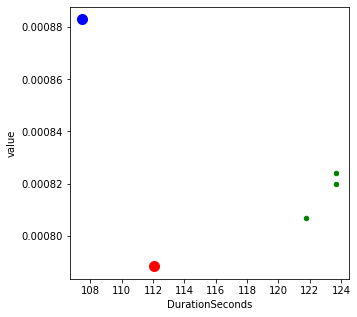

In [107]:
seconds_limit = 70
history = tunerStudy.trials_dataframe()
history["DurationSeconds"] = history.duration.apply(lambda d: d/np.timedelta64(1, 's'))
#history.to_csv(f"./Models/lightGBMBinaryAsphaultStudy_{day}.csv", index=False)
best_params = tunerStudy.best_trial.params
best_score = tunerStudy.best_trial.value
print(f"Best trial:\n\tscore {best_score}\n\ttook {int(tunerStudy.best_trial.duration.seconds/60)} minutes {tunerStudy.best_trial.duration.seconds%60} seconds\n\tparams {json.dumps(best_params, indent=10)}")

best_performers = history[(history.value<(best_score*1.2))]# & (history.DurationSeconds < seconds_limit)]
highestAccuracy = history[history.value == history.value.min()]
highAccuracyLowRun = history[(history.DurationSeconds < highestAccuracy.DurationSeconds.max()*1.5) & (history.value < best_score / 0.95)]
optimum_trial = best_performers[best_performers.DurationSeconds == best_performers.DurationSeconds.min()] 
optimum_trial_number = optimum_trial.number.values[0]
optimum_score = optimum_trial.value.values[0]
optimum_time = optimum_trial.DurationSeconds.values[0]
optimum_params = tunerStudy.get_trials()[optimum_trial_number].params
print(f"Optimum trial (#{optimum_trial_number}): \n\tscore {optimum_score} \n\ttook {int(optimum_time/60)} minutes {round(optimum_time%60,1)} seconds \n\tparams: {json.dumps(optimum_params, indent=10)}")

ax1 = highAccuracyLowRun.plot(kind='scatter', x='DurationSeconds', y='value', color='green', s=20, figsize=(5,5))    
ax2 = highestAccuracy.plot(kind='scatter', x='DurationSeconds', y='value', color='red', s=100, ax=ax1)
ax3 = optimum_trial.plot(kind='scatter', x='DurationSeconds', y='value', color='blue', s=100, ax=ax1)

Best trial:
	score 0.0007565977694676177
	took 1 minutes 31 seconds
	params {
          "lambda_l1": 0.028664020826938516,
          "lambda_l2": 1.3198683384921155e-08
}
Optimum trial (#20): 
	score 0.000775853596216345 
	took 1 minutes 4.0 seconds 
	params: {
          "num_leaves": 124
}


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


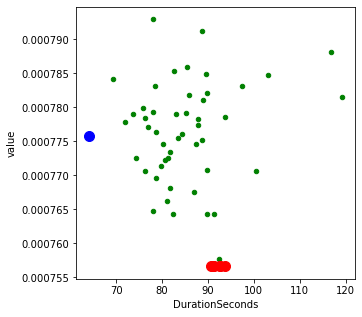

In [49]:
seconds_limit = 70
history = study.trials_dataframe()
history["DurationSeconds"] = history.duration.apply(lambda d: d/np.timedelta64(1, 's'))
history.to_csv(f"./Models/lightGBMBinaryAsphaultStudy_{day}.csv", index=False)
best_params = study.best_trial.params
best_score = study.best_trial.value
print(f"Best trial:\n\tscore {best_score}\n\ttook {int(study.best_trial.duration.seconds/60)} minutes {study.best_trial.duration.seconds%60} seconds\n\tparams {json.dumps(best_params, indent=10)}")

best_performers = history[(history.value<(best_score*1.2))]# & (history.DurationSeconds < seconds_limit)]
highestAccuracy = history[history.value == history.value.min()]
highAccuracyLowRun = history[(history.DurationSeconds < highestAccuracy.DurationSeconds.max()*1.5) & (history.value < best_score / 0.95)]
optimum_trial = best_performers[best_performers.DurationSeconds == best_performers.DurationSeconds.min()] 
optimum_trial_number = optimum_trial.number.values[0]
optimum_score = optimum_trial.value.values[0]
optimum_time = optimum_trial.DurationSeconds.values[0]
optimum_params = study.get_trials()[optimum_trial_number].params
print(f"Optimum trial (#{optimum_trial_number}): \n\tscore {optimum_score} \n\ttook {int(optimum_time/60)} minutes {round(optimum_time%60,1)} seconds \n\tparams: {json.dumps(optimum_params, indent=10)}")

ax1 = highAccuracyLowRun.plot(kind='scatter', x='DurationSeconds', y='value', color='green', s=20, figsize=(5,5))    
ax2 = highestAccuracy.plot(kind='scatter', x='DurationSeconds', y='value', color='red', s=100, ax=ax1)
ax3 = optimum_trial.plot(kind='scatter', x='DurationSeconds', y='value', color='blue', s=100, ax=ax1)

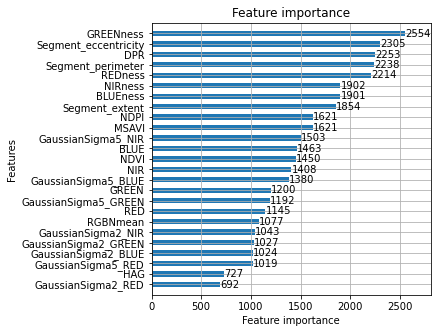

In [186]:
olgb.plot_importance(model, height=0.5, figsize=(5,5))

In [30]:
finished()

In [46]:
from skimage.morphology import binary_closing, binary_opening, square, remove_small_holes, disk, square, remove_small_objects

def fillHolesInClass(array, class_num, size_max):
    class_bool = array == class_num
    array[class_bool] = 255
    filled = remove_small_holes(class_bool, area_threshold=size_max, connectivity=1)
    array[filled] = class_num
    return array
    

def removeClassSmaller(array, class_num, min_size):
    non = np.where(array==class_num, 255, array)
    removed = remove_small_objects(array==class_num, min_size=min_size, connectivity=1)
    array_rem = np.where(removed==0, non, array)
    return array_rem


def cleanupAsphault(a):
    # remove smaller than 
    a = remove_small_objects(a==1, min_size=1000, connectivity=1)
    
    a = fillHolesInClass(a, 9, 90)
    # open and dilate and 
    for i in range(5):
        a = binary_opening(a, square(3))
        a = binary_closing(a, square(5))
        
    return a 

In [47]:
with rio.open("../EPCExtent_30cm\Orthos_Segmented_Classifiedv3\W989789_W439850_TrainingStackV3_AsphaultBinaryLGBNewishGBLM.tif") as src:
    asphault = src.read(1)
    kwargs = src.profile

with rio.open("C:/Users/BenJames/Downloads/testAsphault.tif", "w", **kwargs) as dst:
    dst.write(cleanupAsphault(asphault).astype(np.uint8), 1)

